# Polygon extraction
To extract the relevant data from the underlying image of Europe.  
![Europe 1918](input/europe_1918.png)
## 1. Remove non-map data
Such as : 
- The year indicator
- The population count
- The author's logo
- The countries' names
### 1.1. Manually remove logos and text

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage import color
from shapely.geometry import box
from skimage import transform

import time

start_time = time.time()

def display_img(img, title="", big=False) : 
    if big : 
        fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.show()

europe = color.rgba2rgb(plt.imread('input/europe_1918.png'))
display_img(europe, 'Europe 1918', True)

def disp_polygons(img, polygons, saveTo='') :
    todisp = img.copy()
    for polygon in polygons :
        (minx, miny, maxx, maxy) = np.array(polygon.bounds).astype(int)
        cv2.rectangle(todisp, (minx, miny), (maxx, maxy), (0, 0, int(np.max(todisp))), 2)
    display_img(todisp, '', True)
    if saveTo :
        plt.imsave(saveTo, todisp)
                      
def fill_polygons(img, polygons, fill_colors):
    res = img.copy()
    if np.ndim(fill_colors) == 1:
        fill_colors = [list(fill_colors)] * len(polygons)
    for i, polygon in enumerate(polygons) :
        [_, (xb, yb), _, (xa, ya), _] = [(int(x), int(y)) for (x, y) in polygon.exterior.coords]
        res[ya:yb, xa:xb] = fill_colors[i]
    return res
def display_colours(color_list) :
    size = len(color_list)
    plt.bar(range(size), [1]*size  , color=color_list)
    plt.show()

def get_surrounding_colors(img, polygon : box):
    offset = 1
    color_list = np.zeros((len(polygon.exterior.coords) , 3))
    x_left = int(np.array(polygon.exterior.coords)[:, 0].min()) - offset
    x_right = int(np.array(polygon.exterior.coords)[:, 0].max()) + offset
    y_top = int(np.array(polygon.exterior.coords)[:, 1].min()) - offset
    y_bottom = int(np.array(polygon.exterior.coords)[:, 1].max()) + offset
    corners =np.concatenate((
        img[y_top, x_left:x_right],
        img[y_bottom, x_left:x_right],
        img[y_top:y_bottom, x_left],
        img[y_top:y_bottom, x_right],
    ))
    res = np.median(corners, axis=0)
    return res
    
    
population_text_box = box(10, 230, 600, 1050)
logo_text_box = box(10, 10, 170, 150)
year_text_box_1 = box(800, 10, 1040, 150)
year_text_box_2 = box(1030, 30, 1070, 130)

to_remove = [population_text_box, logo_text_box, year_text_box_1, year_text_box_2]
surrounding_colors = [get_surrounding_colors(europe, box) for box in to_remove]
disp_polygons(europe, to_remove)

europe_cleaned = fill_polygons(europe, to_remove, surrounding_colors)
#europe_cleaned = transform.resize(europe_cleaned, (europe_cleaned.shape[0]/10, europe_cleaned.shape[1]/10))
display_img(europe_cleaned, 'Only map data are kept', True)

<Figure size 1440x1280 with 1 Axes>

<Figure size 1440x1280 with 1 Axes>

<Figure size 1440x1280 with 1 Axes>

### 1.2. Remove countries' names


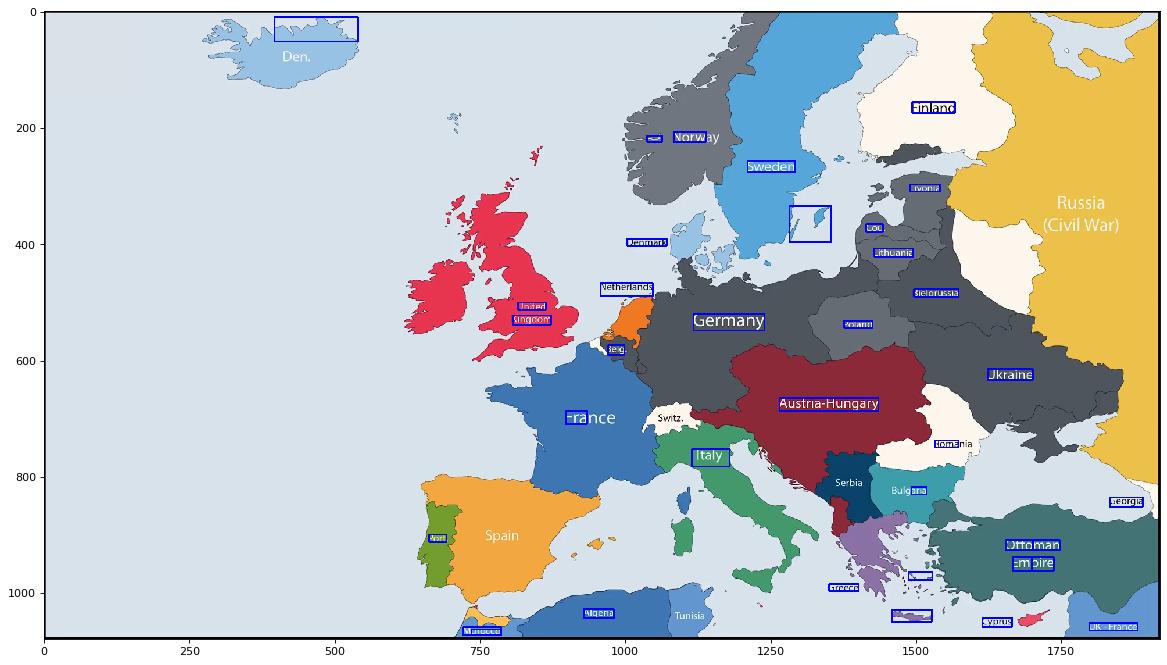

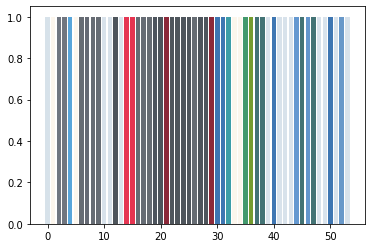

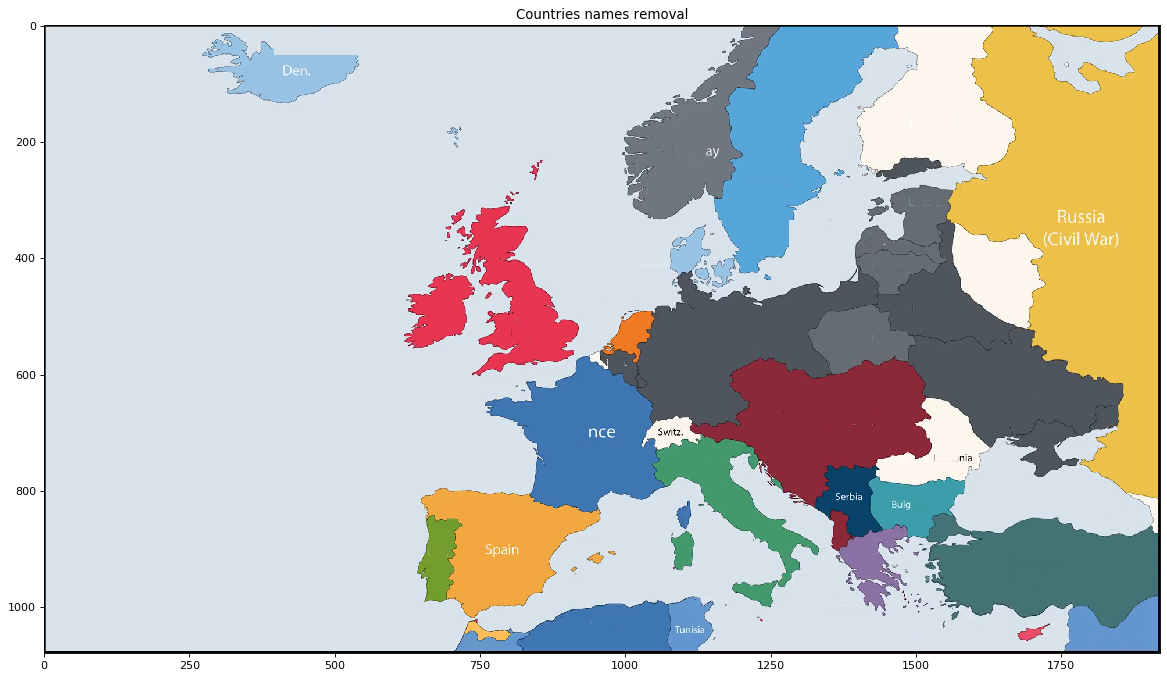

In [2]:
import pytesseract
import pandas as pd

from pytesseract import Output
from pprint import pprint
def filter_recognition_results(df):
    significantLetters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
    authorizedLetters = significantLetters + "'-. ()"
    
    #At least 3 significant letters
    isLongEnough = lambda x : len([char for char in x if char in significantLetters]) >= 3
    noForbidden = lambda x : ''.join([char for char in x if char in authorizedLetters]) == x
    # Removing empty
    validity_array = [isLongEnough(row['text']) and noForbidden(row['text']) for _, row in df.iterrows()]
    return df[validity_array]
    
def apply_tesseract(img) :
    plt.imsave('tmp/tesseract_input_gray.png', color.rgb2gray(img), cmap='gray')
    d = pytesseract.image_to_data('tmp/tesseract_input_gray.png', config="--oem 3 --psm 11",lang='eng', output_type=Output.DICT)
    plt.imsave('tmp/tesseract_input_color.png', img, cmap='gray')
    d_color = pytesseract.image_to_data('tmp/tesseract_input_color.png', config="--oem 3 --psm 11",lang='eng', output_type=Output.DICT)
    boxes = []
    bboxes = pd.DataFrame(columns=['bbox'])
    df = filter_recognition_results(pd.DataFrame(d))
    df = df.append(filter_recognition_results(pd.DataFrame(d_color)))
    for i, row in df.iterrows():
        (x, y, w, h) = (row['left'], row['top'], row['width'], row['height'])
        boxes.append(box(x, y, x+w, y+h))
        bboxes.loc[i] =  [box(x, y, x+w, y+h)]
    disp_polygons(img, bboxes['bbox'].values)
    return bboxes.join(df.text).reset_index()

countries_names = apply_tesseract(europe_cleaned )

# Text removal when possible
fill_colors = [get_surrounding_colors(europe_cleaned, bbox) for bbox in countries_names['bbox'].values]
display_colours(fill_colors)
europe_cleaned = fill_polygons(europe_cleaned , countries_names['bbox'].values , fill_colors)
display_img(europe_cleaned, 'Countries names removal', True)

## 2. Keep only the relevant colors

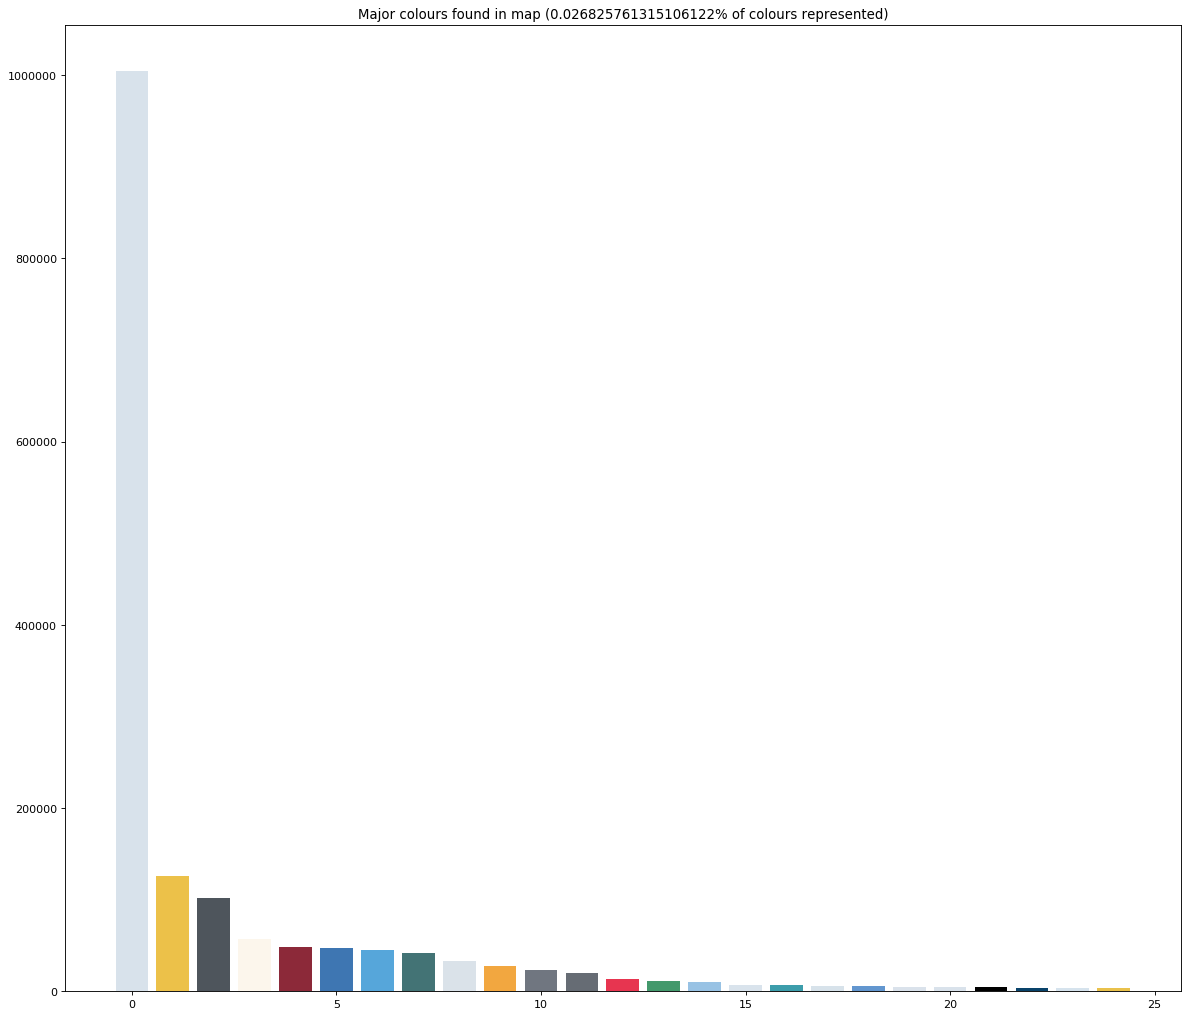

In [3]:
def extract_major_colors(img) :
    unique, counts = np.unique(img.reshape(int(img.size/3), 3), axis=0, return_counts=True)
    scores = list(zip(counts, unique))
    df = pd.DataFrame(scores, columns=['count', 'value']).sort_values(by=['count'], ascending=False)
    return df
def print_colors(extracted_colors):
    toplot = extracted_colors[:25]
    percentage = 100 * len(toplot)/len(extracted_colors)
    fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.bar(np.arange(len(toplot)) , toplot['count'].values , color=toplot['value'].values)
    plt.title('Major colours found in map ('+str(percentage)+'% of colours represented)')
    plt.show()
extracted =  extract_major_colors(europe_cleaned)
print_colors(extracted)

As displayed above, the image contains way too many colours. If we plan to extract countries based on colours, we'll first have to regroup these colours to make sense.  
This cane be done with the following clustering algorithm

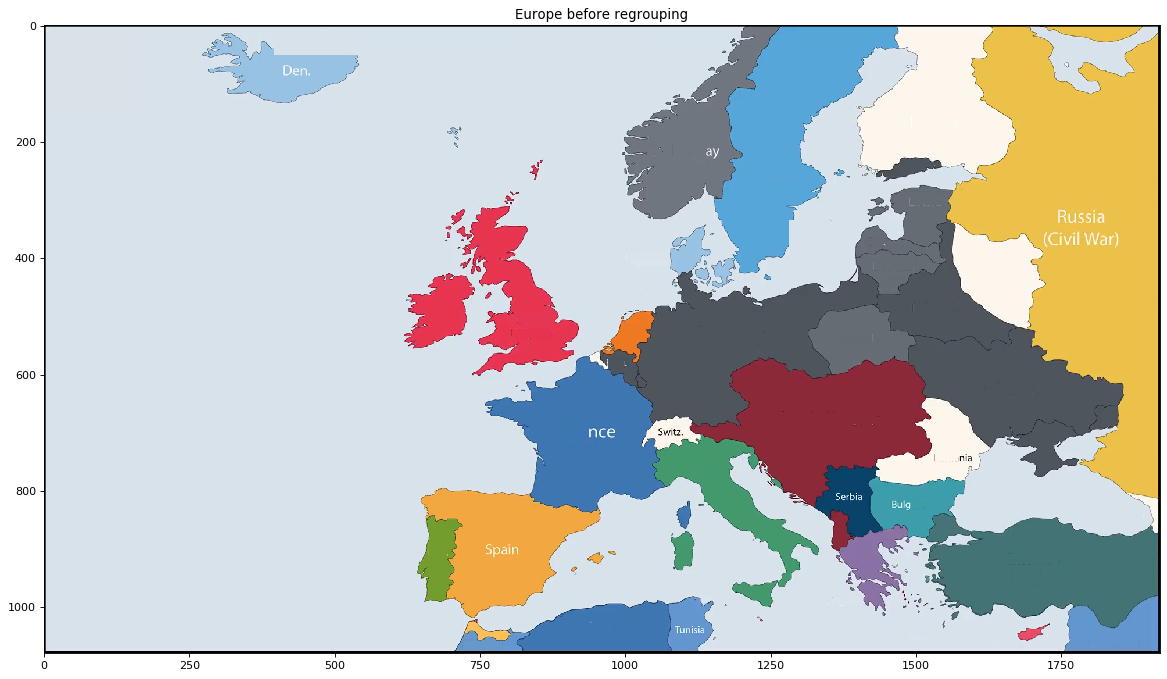

CPU times: user 8.24 s, sys: 124 ms, total: 8.36 s
Wall time: 7.52 s


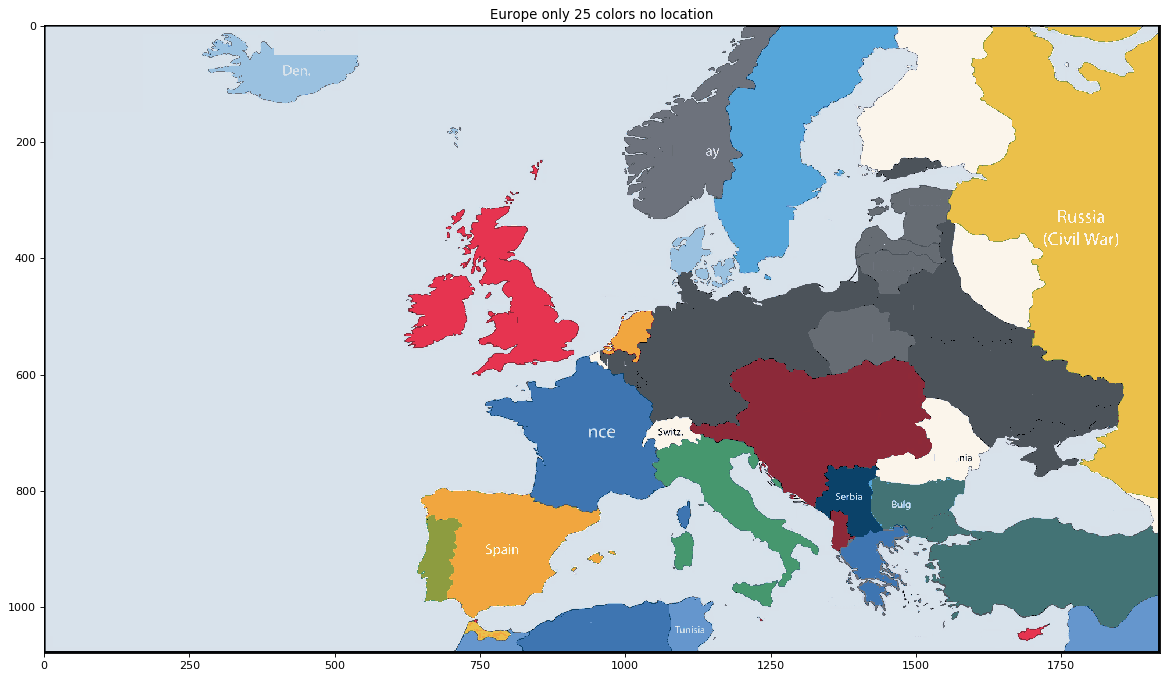

In [4]:
from sklearn.cluster import MiniBatchKMeans
def regroup_colors(image, nb_color, include_location=True) :
    (h, w) = image.shape[:2]
    data = image.copy()
    # Lab is a colour representation (l, a , b). 
    #It is made so that if (l, a , b) differs numerically, the perceived colour by humans will also differ
    data = color.rgb2lab(data)
    #Adding location
    if include_location :
        col_num = (np.arange(w)/w * 100).reshape((1, w)).repeat(h, axis=0).reshape((h, w, 1))
        row_num = (np.arange(h)/h * 100).repeat(w).reshape((h, w, 1))
        data = np.c_[data, row_num, col_num]
    
    #With location added, kmeans
    data = data.reshape((h*w, 5 if include_location else 3))
    clt = MiniBatchKMeans(n_clusters = nb_color, random_state = 0)
    labels = clt.fit_predict(data)
    res = clt.cluster_centers_[labels].reshape((h, w, 5 if include_location else 3))
    if include_location :
        #removing location info
        res = res[:, :, :3]
    res = color.lab2rgb(res)
    return res

def exploreLAB(labimg):
    l = labimg[:, :, 0].flatten()
    a = labimg[:, :, 1].flatten()
    b = labimg[:, :, 2].flatten()
    plt.hist(l, bins=100)
    plt.hist(a, bins=100)
    plt.hist(b, bins=100)
    plt.show()
nb_color = 25
display_img(europe_cleaned, "Europe before regrouping", True)
#exploreLAB(color.rgb2lab(europe_cleaned))
#%time clustered_europe = regroup_colors(europe_cleaned, nb_color, True)
#display_img(clustered_europe, "Europe only "+str(nb_color)+" colors  with location", True)
%time clustered_europe_no_location = regroup_colors(europe_cleaned, nb_color, False)
display_img(clustered_europe_no_location, "Europe only "+str(nb_color)+" colors no location", True)

In [5]:
plt.imsave('tmp/clustered_europe.png', clustered_europe_no_location)

Now, the colour count has a meaning

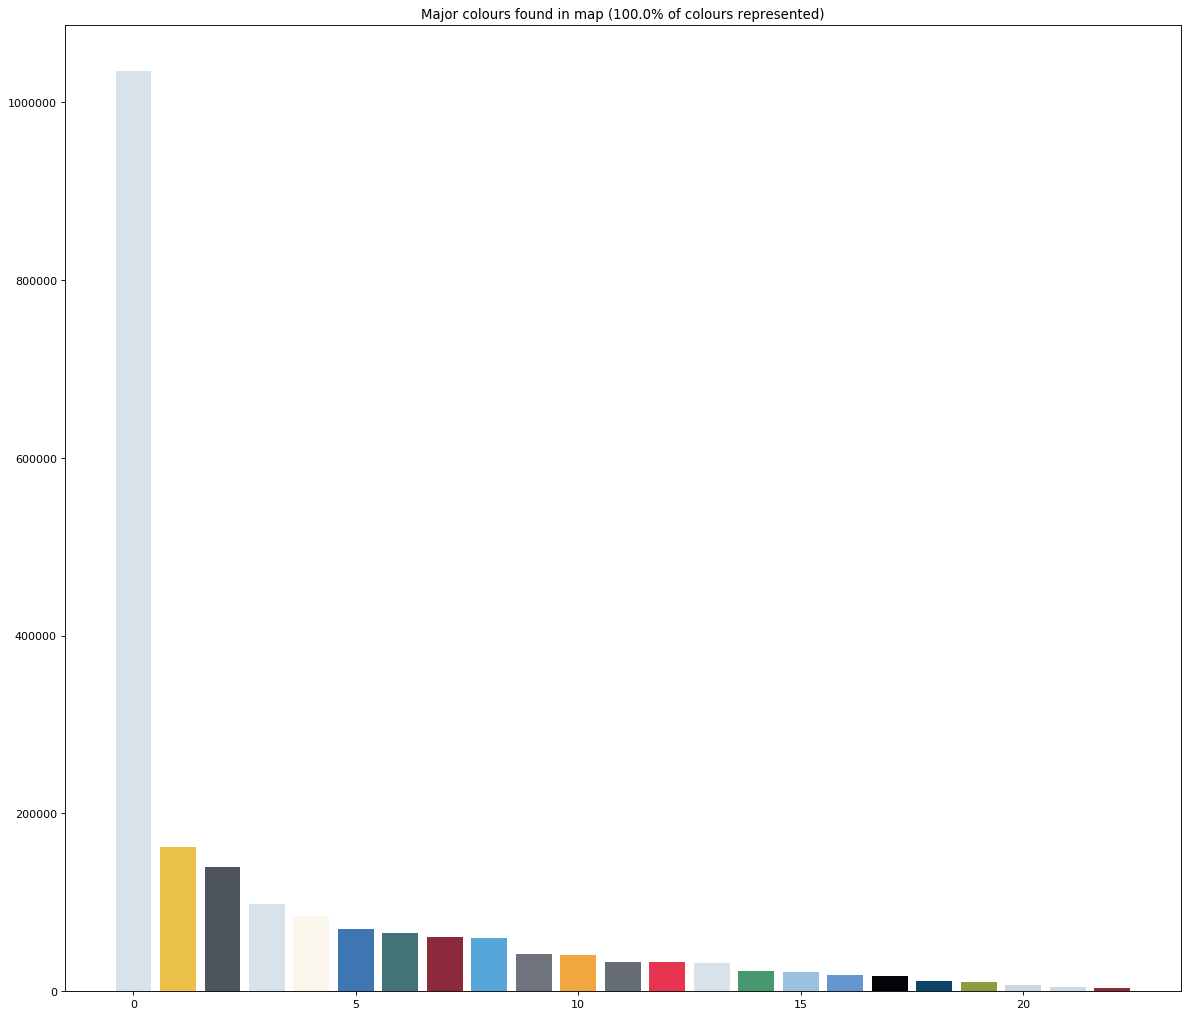

In [6]:
extracted_colors =  extract_major_colors(clustered_europe_no_location)
print_colors(extracted_colors)

In [7]:
extracted_colors.to_pickle('tmp/extracted_colors.pkl')
extracted_colors

,count,value
17,1035261,"[0.8470588949527849, 0.886274574714946, 0.9215..."
20,162447,"[0.9240002515067238, 0.7551961546367674, 0.291..."
5,140222,"[0.3016762372726491, 0.32894595212036565, 0.35..."
18,98011,"[0.8471522780460341, 0.8859076037779491, 0.920..."
22,84161,"[0.9851600221802045, 0.9638881985400695, 0.924..."
2,69823,"[0.24430341323214816, 0.4619198292733792, 0.69..."
3,65428,"[0.26416355266212577, 0.45271751419362444, 0.4..."
10,60473,"[0.5507034931012769, 0.1614994559918555, 0.227..."
6,60292,"[0.33876428027175054, 0.6510936426779738, 0.85..."
9,42271,"[0.4297872808633063, 0.4508847711030272, 0.489..."


## Country extraction with a mask
Assuming colours exactly define the country, a mask can be applied to extract the country's borders


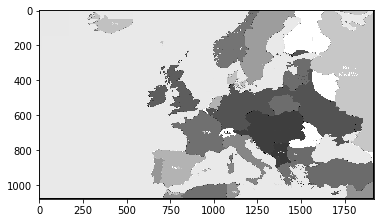

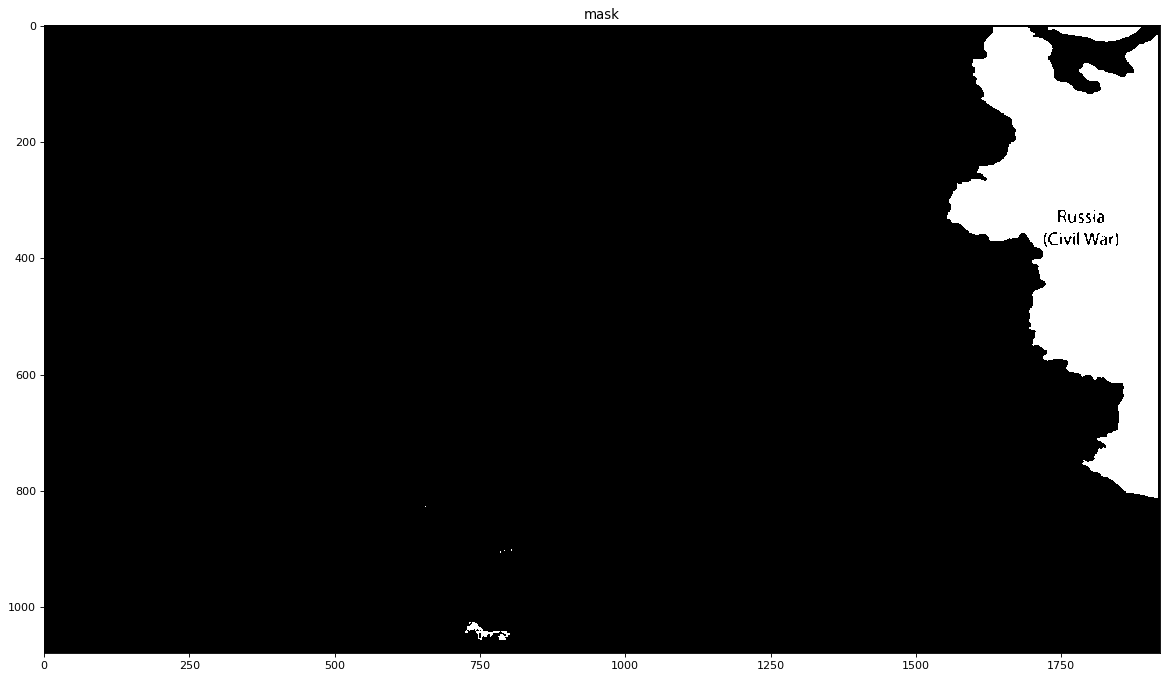

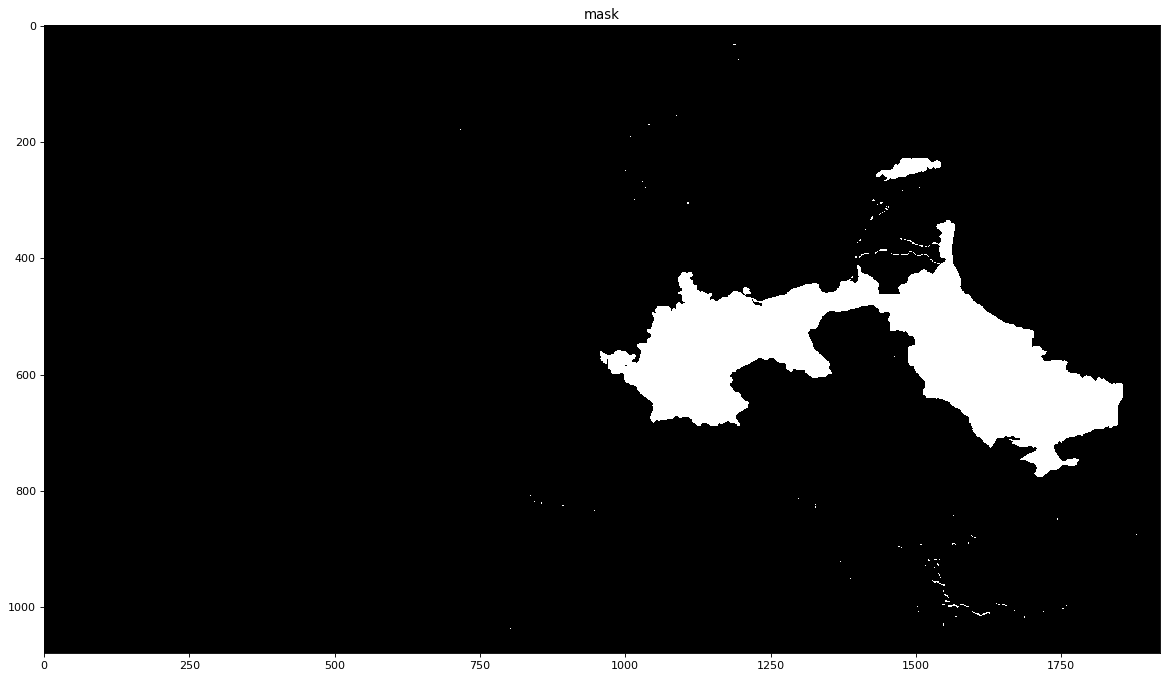

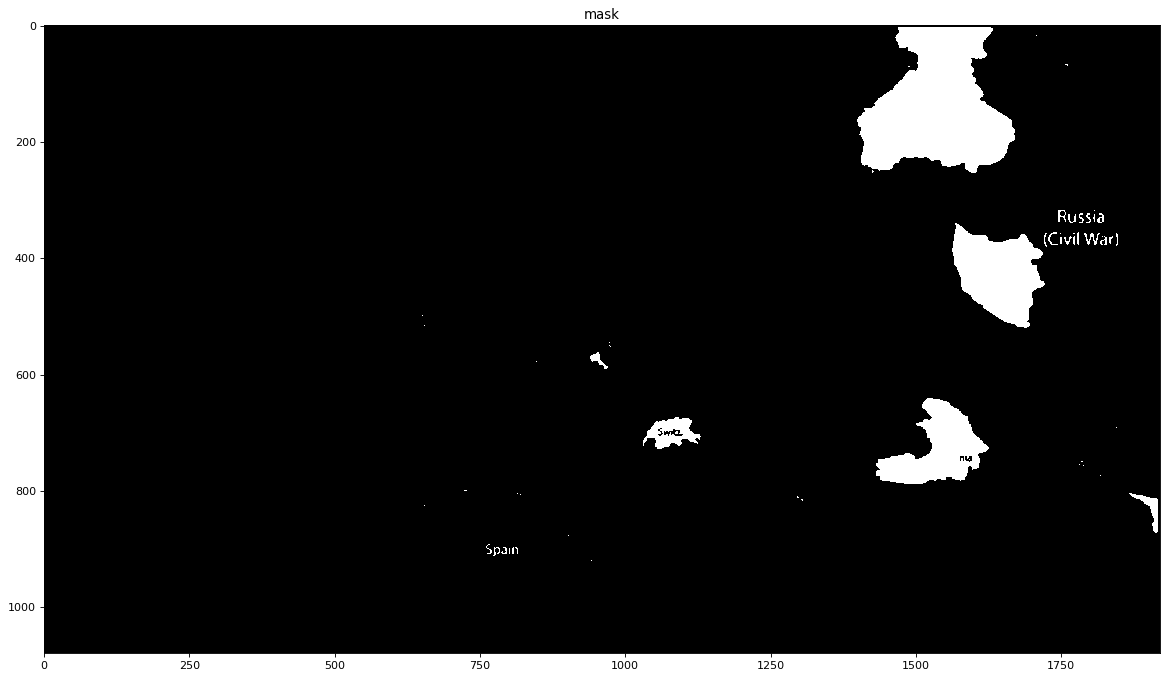

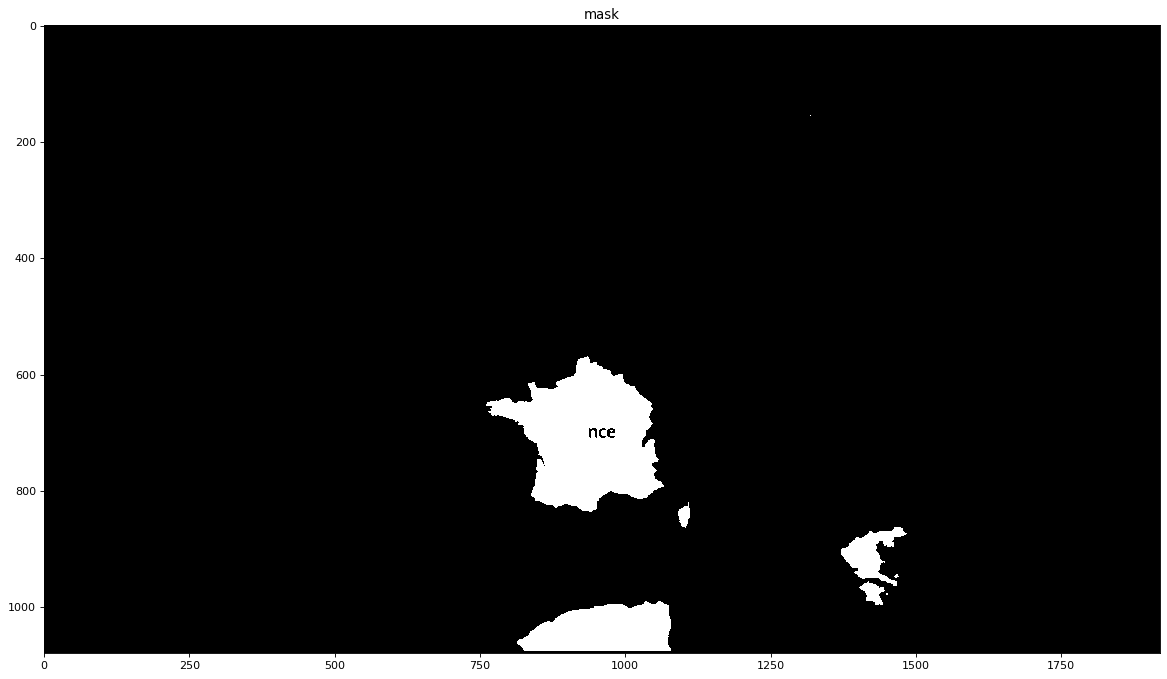

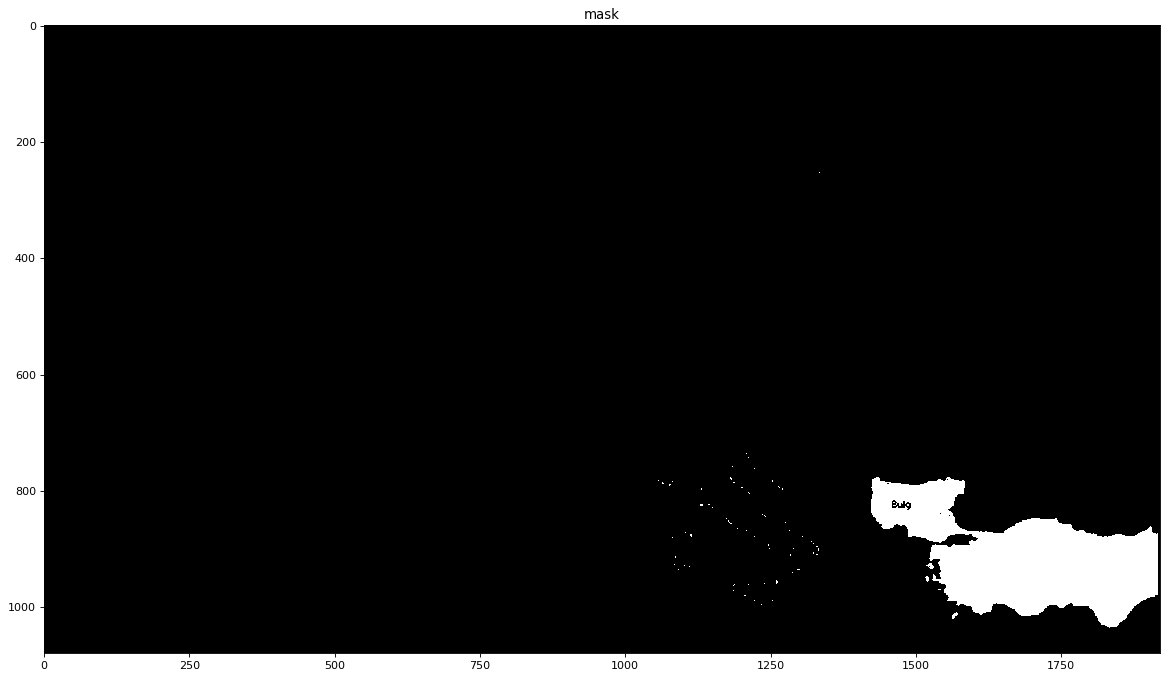

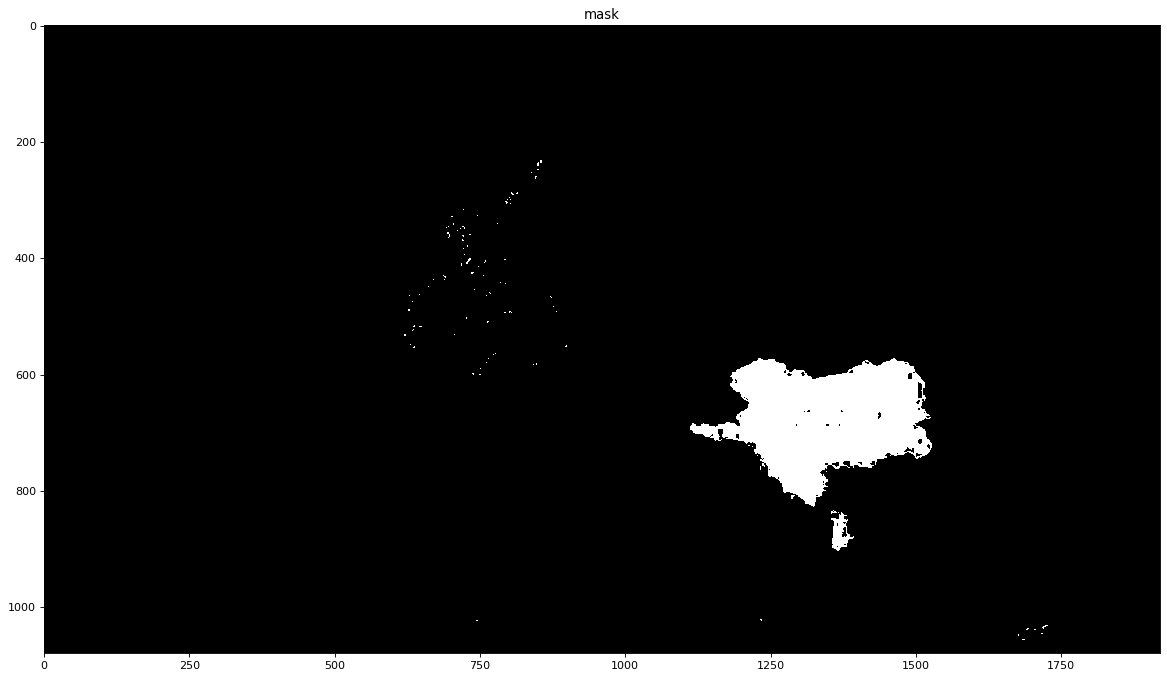

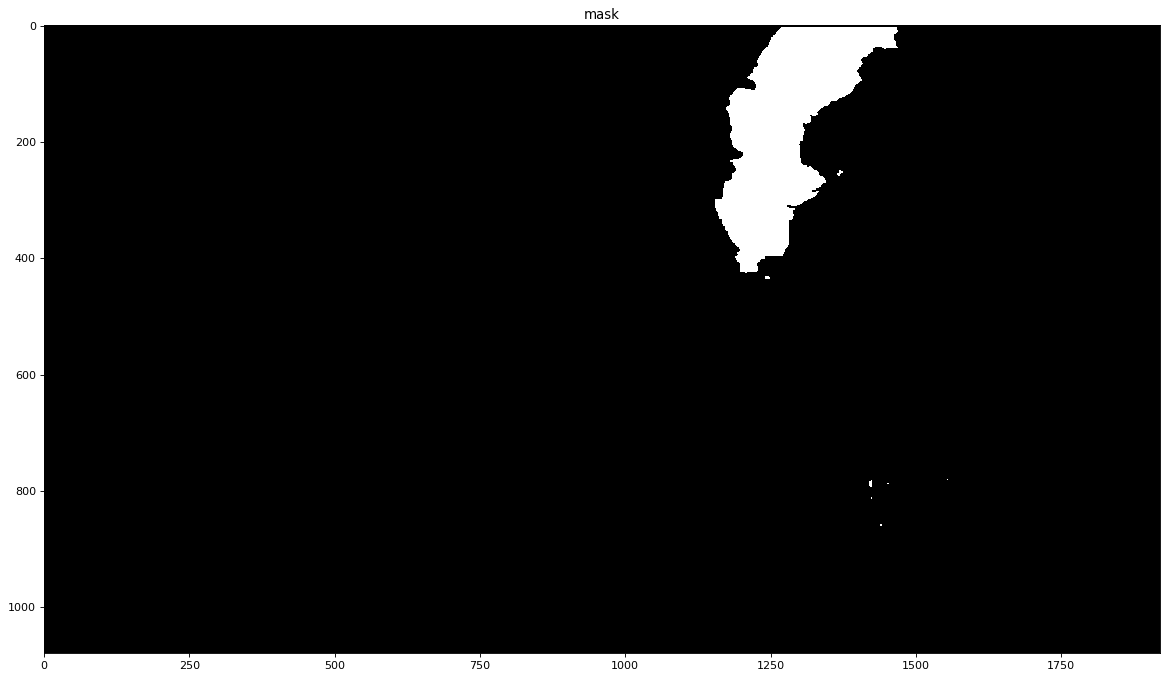

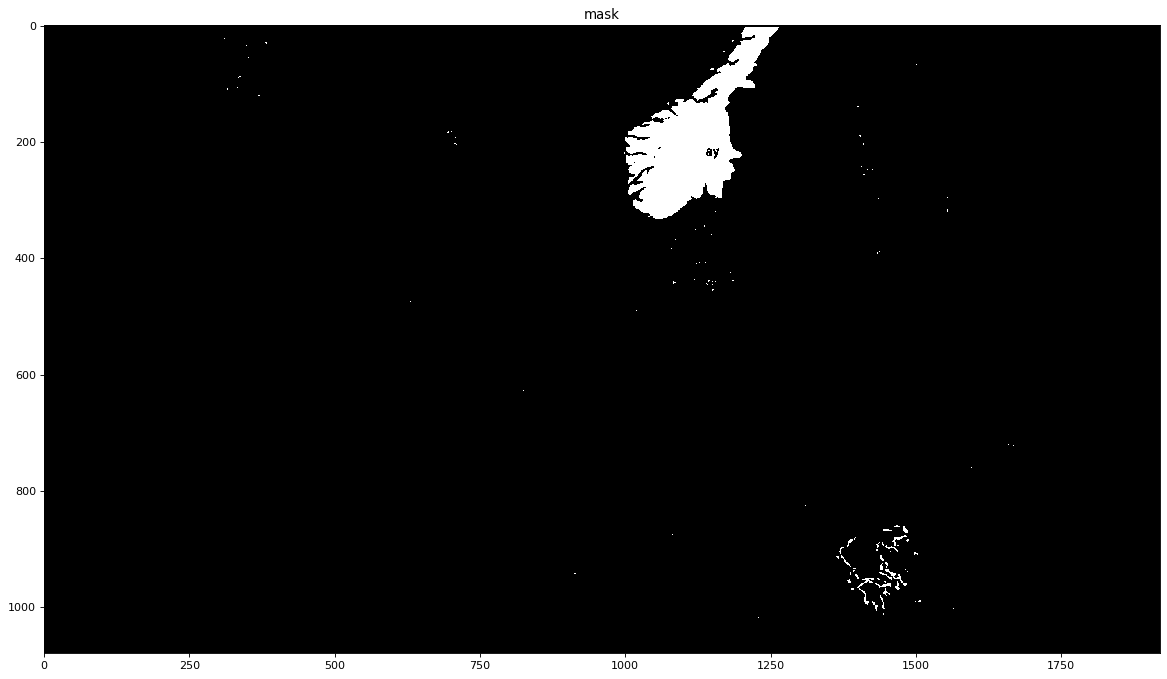

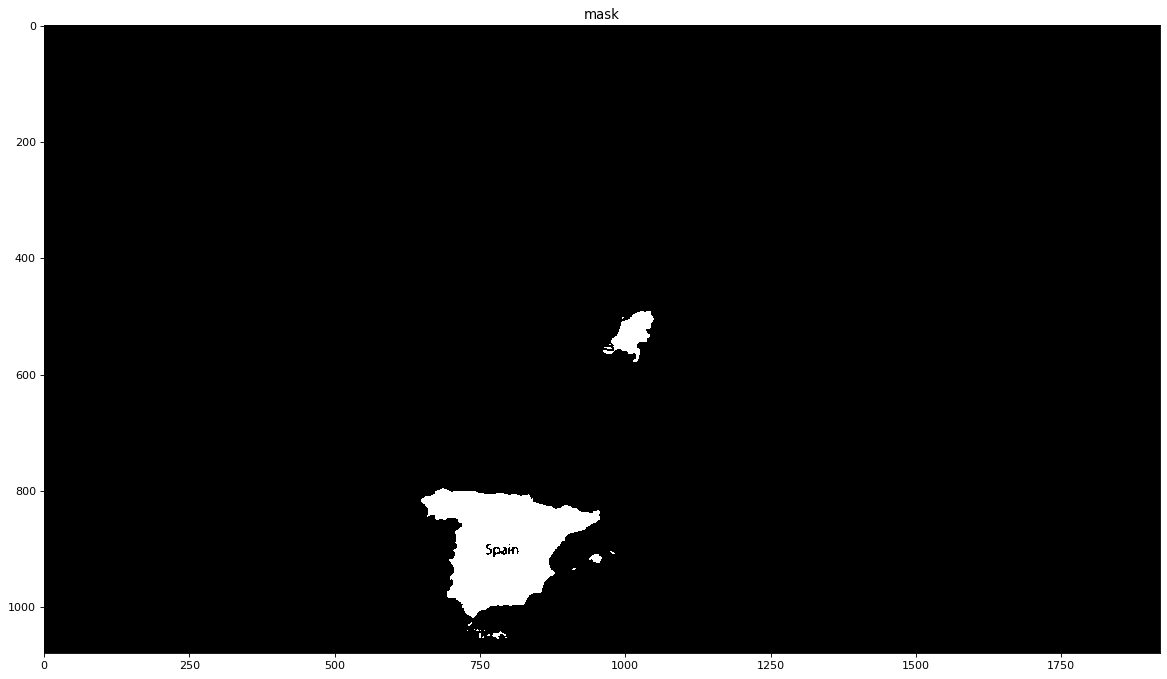

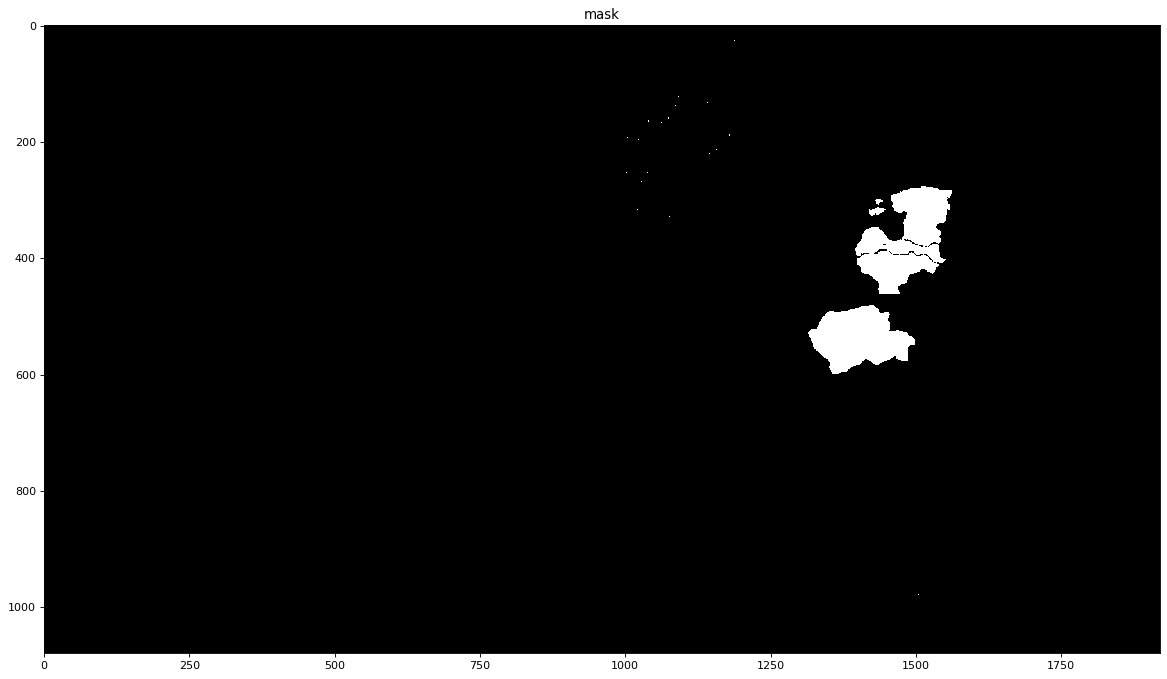

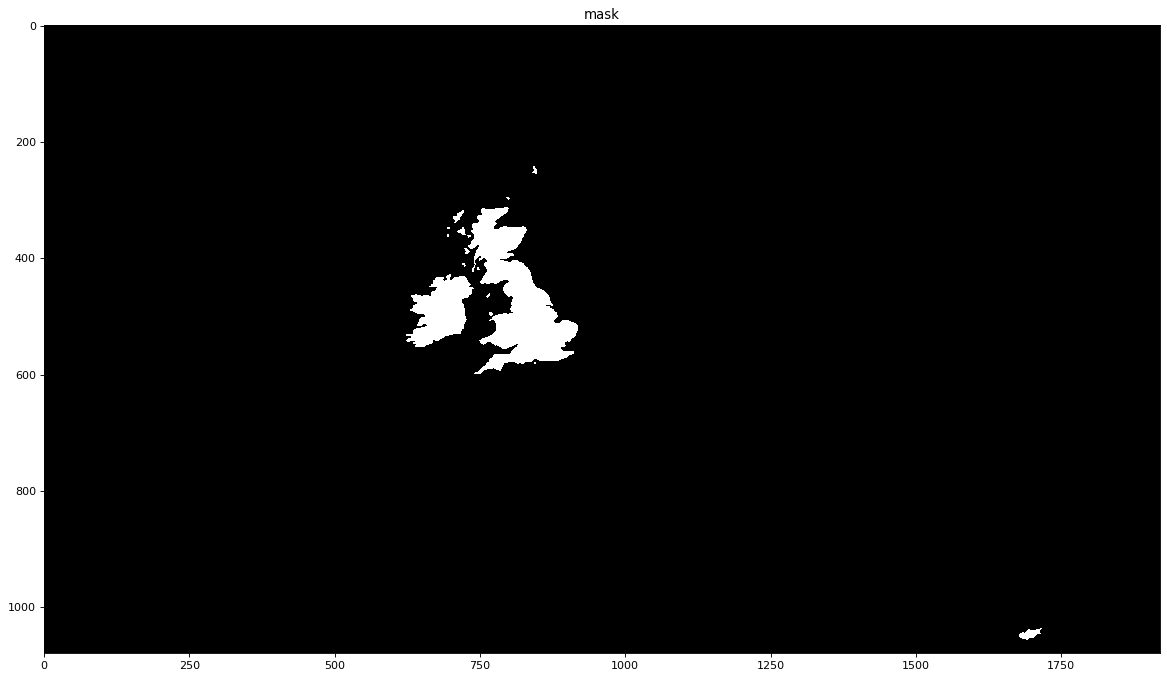

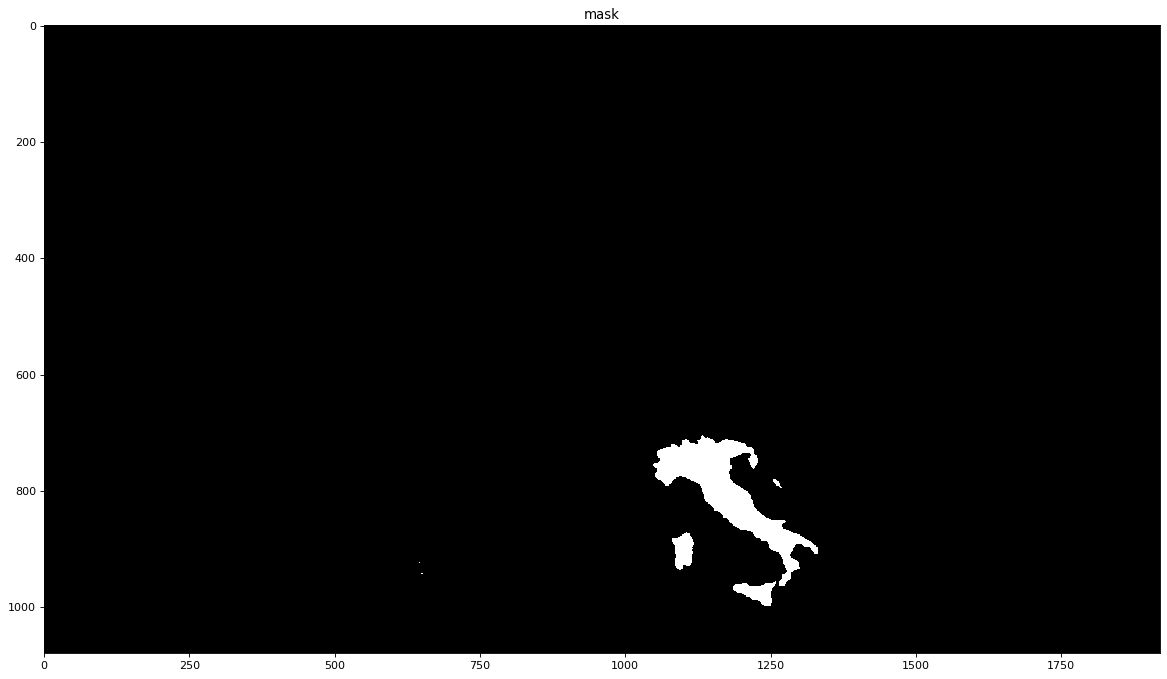

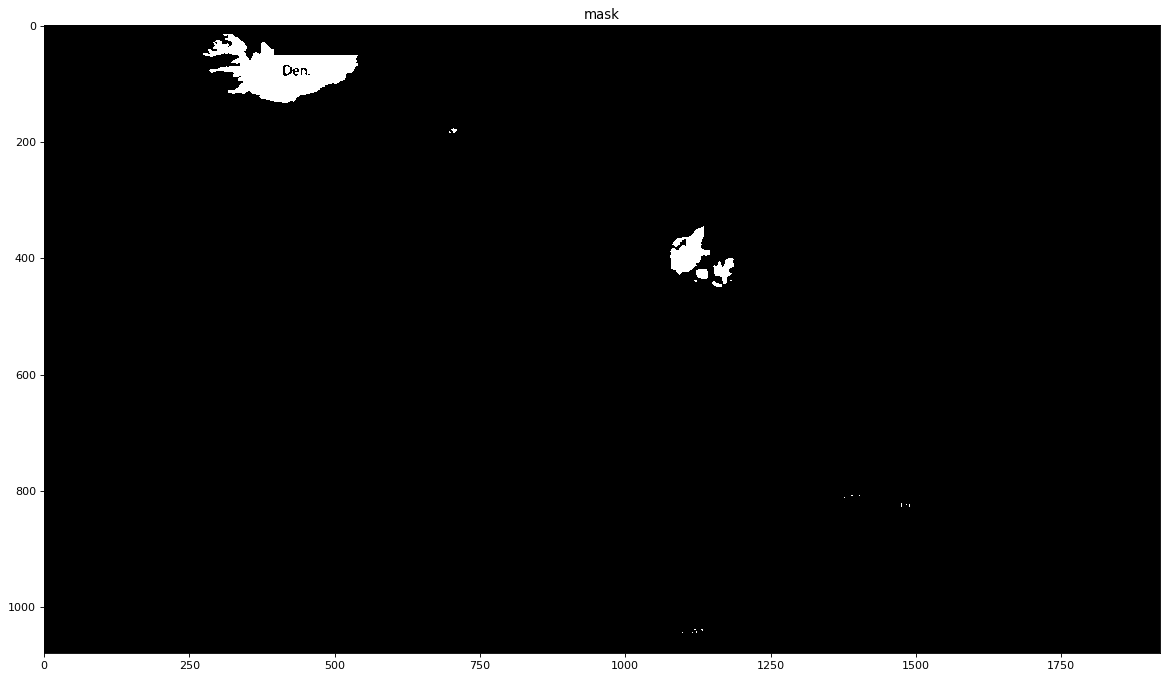

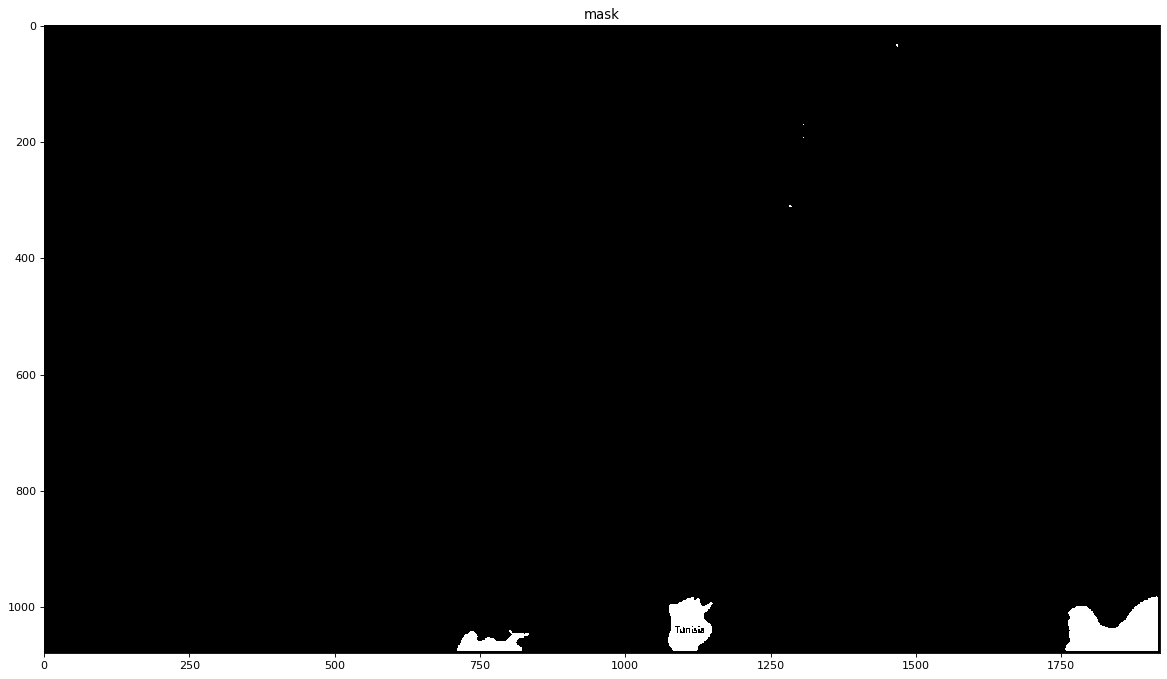

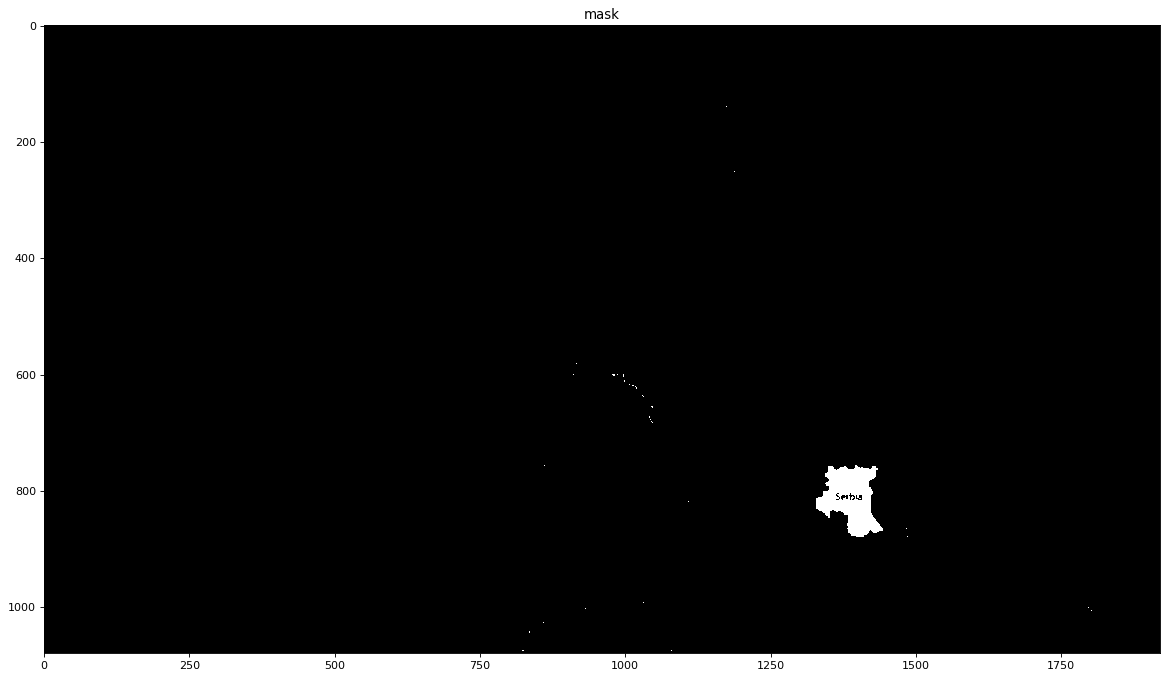

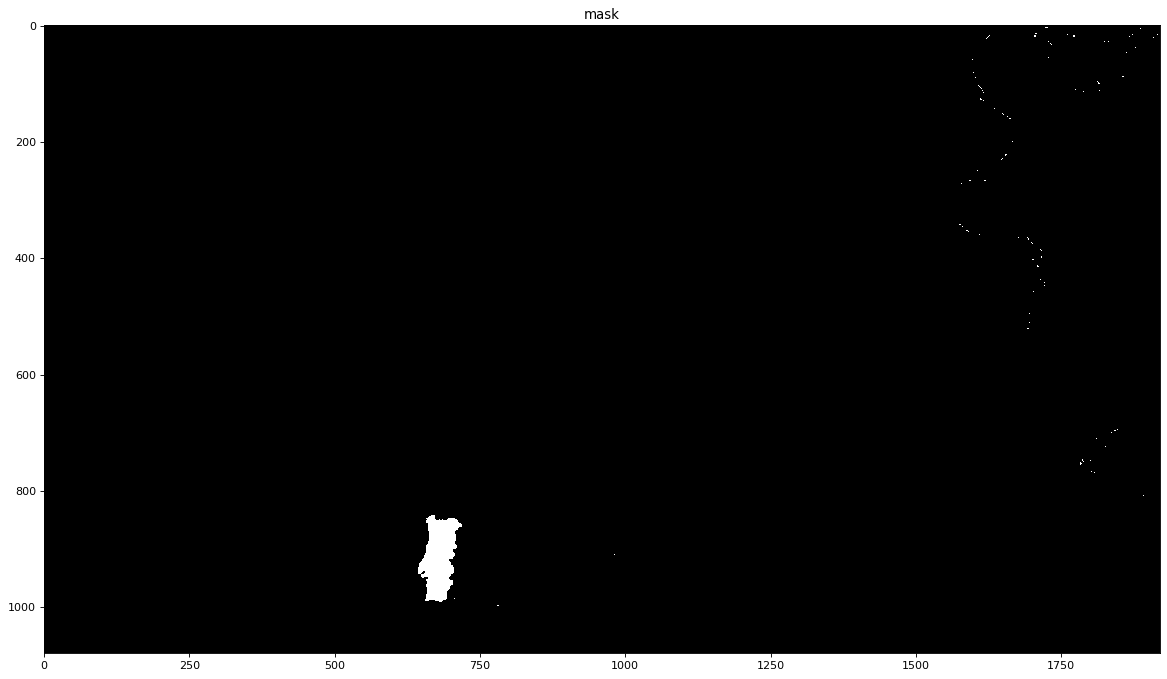

In [8]:
from skimage.filters.rank import median
import skimage.morphology

def get_masked(source_img, colour):
    h, w = source_img.shape[:2]
    return source_img==colour
def noise_reduction(img) : 
    return median(img, selem=np.ones((3, 3)))

def colour_distance(rgb1, rgb2):
    [[lab1, lab2]] = skimage.color.rgb2lab([[rgb1, rgb2]])
    return np.linalg.norm(lab1 - lab2)

grayscale_europe = color.rgb2gray(clustered_europe_no_location)

colors_for_mask = np.concatenate(extracted_colors['value'].values).reshape((len(extracted_colors), 1, 3))
sea_colour = colors_for_mask[0, 0]
land_colors = [color for color in colors_for_mask if colour_distance(sea_colour, color[0]) > 10 ]
grayscale_major_colors = color.rgb2gray(np.array(land_colors)).flatten()
#display_img(grayscale_europe, 'Europe grayscale')
#display_img(grayscale_major_colors, 'Colors in europe', True)
masks = []
display_img(grayscale_europe)
for col in grayscale_major_colors:
    mask = get_masked(grayscale_europe,col)
    masks.append(mask)
masks = [noise_reduction(mask) for mask in masks]


def get_eroded(img) :
    selem = skimage.morphology.disk(6)
    return skimage.morphology.erosion(img, selem)

def is_not_only_borders(bin_img):
    return np.count_nonzero(get_eroded(bin_img)) > 0
masks = [mask for mask in masks if is_not_only_borders(mask)]
for mask in masks :
    display_img(mask, 'mask', True)
#    mask_rgb = np.repeat(mask, 3).reshape(europe.shape)
 #   display_img(np.where(mask_rgb, europe, np.ones(europe_cleaned.shape)), "One color extraction", True)


Let's consider France

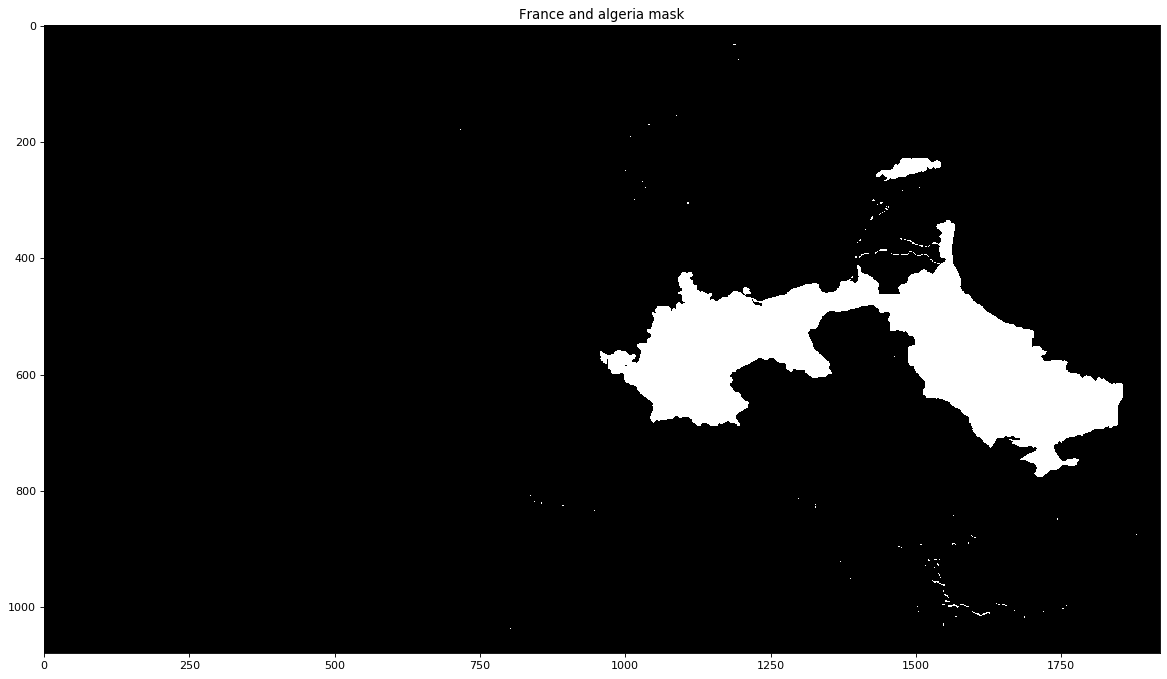

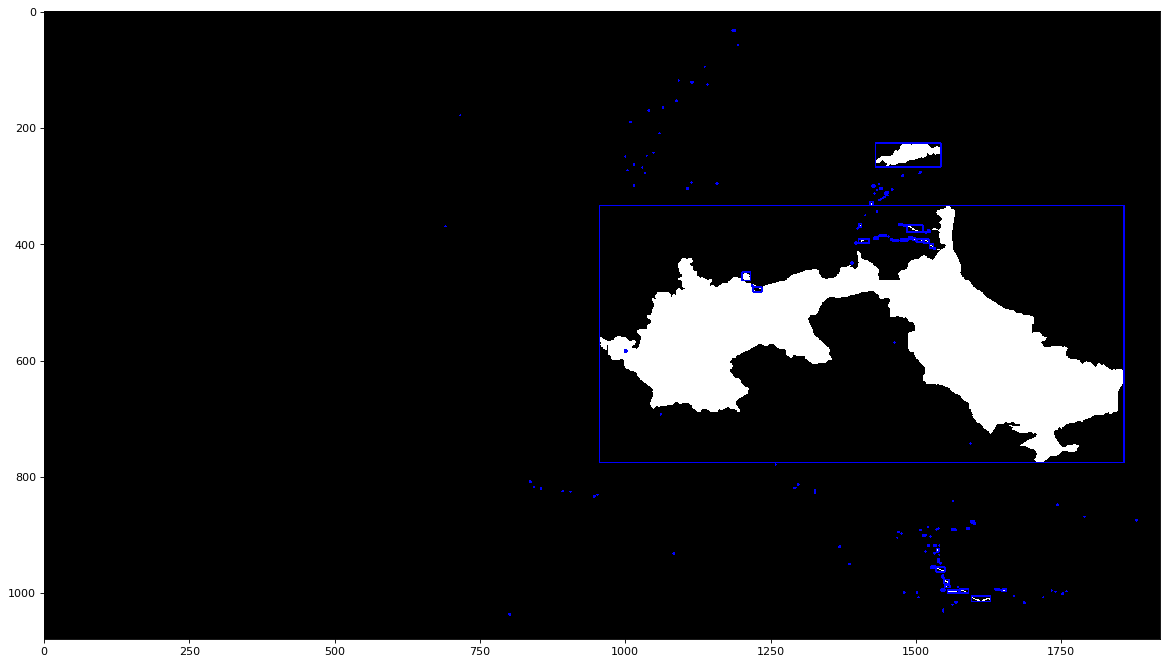

In [9]:
from skimage import measure
from shapely.geometry import Polygon
import skimage.color
def get_polygons(mask):
    contours = measure.find_contours(mask, 0.8)
    return [Polygon(list(zip(contour[:, 1], contour[:, 0]))) for contour in contours]

def drawShape(img, coordinates, color) :
    # In order to draw our line in red
    img = skimage.color.gray2rgb(img)

    # Make sure the coordinates are expressed as integers
    coordinates = coordinates.astype(int)

    img[coordinates[:, 0], coordinates[:, 1]] = color

    return img

fr_mask = masks[1]
display_img(fr_mask, 'France and algeria mask', True)
disp_polygons(skimage.color.gray2rgb(fr_mask), get_polygons(fr_mask))

That's a lot of polygons. The number of polygons can be reduced if letters and too small polygons are removed


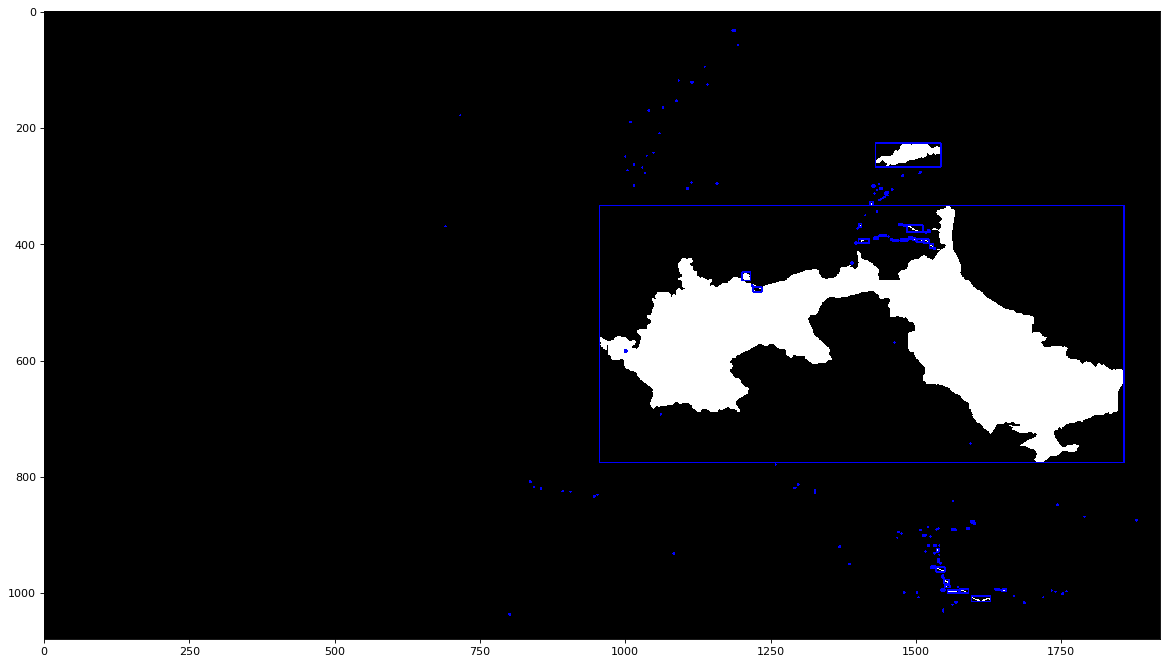

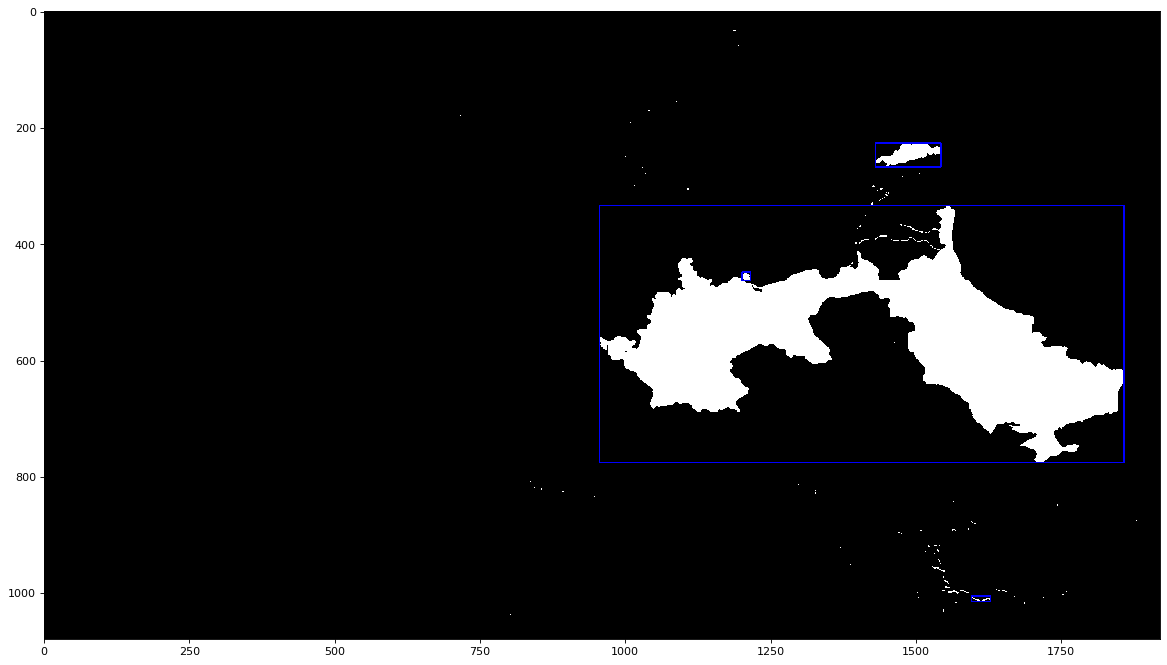

Kept  4 polygons


In [10]:
import skimage.draw
def is_letter(polygon, mask):
    (minx, miny, maxx, maxy) = np.array(polygon.bounds).astype(int)
    area = mask[miny:maxy , minx:maxx].copy()
    area[area!=0] = 1
    coords = np.array(polygon.exterior.coords)
    rr, cc = skimage.draw.polygon(coords[:, 1], coords[:, 0])
    overlay = np.zeros(area.shape)
    overlay[rr-miny-1, cc-minx-1] = 1
    matching = area==overlay
    score = np.count_nonzero(matching)/matching.size
#    if score < 0.5 and polygon.area > 100 :
 #       print('images that did not work')
  #      display_img(area)
   #     display_img(overlay)
    #    display_img(matching)    
    return score < 0.5

def is_big_enough(polygon):
    return polygon.area > 100

def is_significant(polygon, mask):
    return is_big_enough(polygon) and not is_letter(polygon, mask)

def filter_polygons(polygons, mask):
    return [polygon for polygon in polygons if is_significant(polygon, mask)]

found_poly = get_polygons(fr_mask)
disp_polygons(color.gray2rgb(fr_mask), found_poly)
kept_polygons = filter_polygons(found_poly, fr_mask)
disp_polygons(skimage.color.gray2rgb(fr_mask), kept_polygons)
print('Kept ', len(kept_polygons), 'polygons')

Now for every map

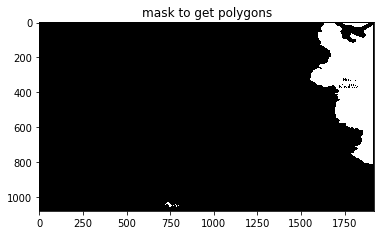

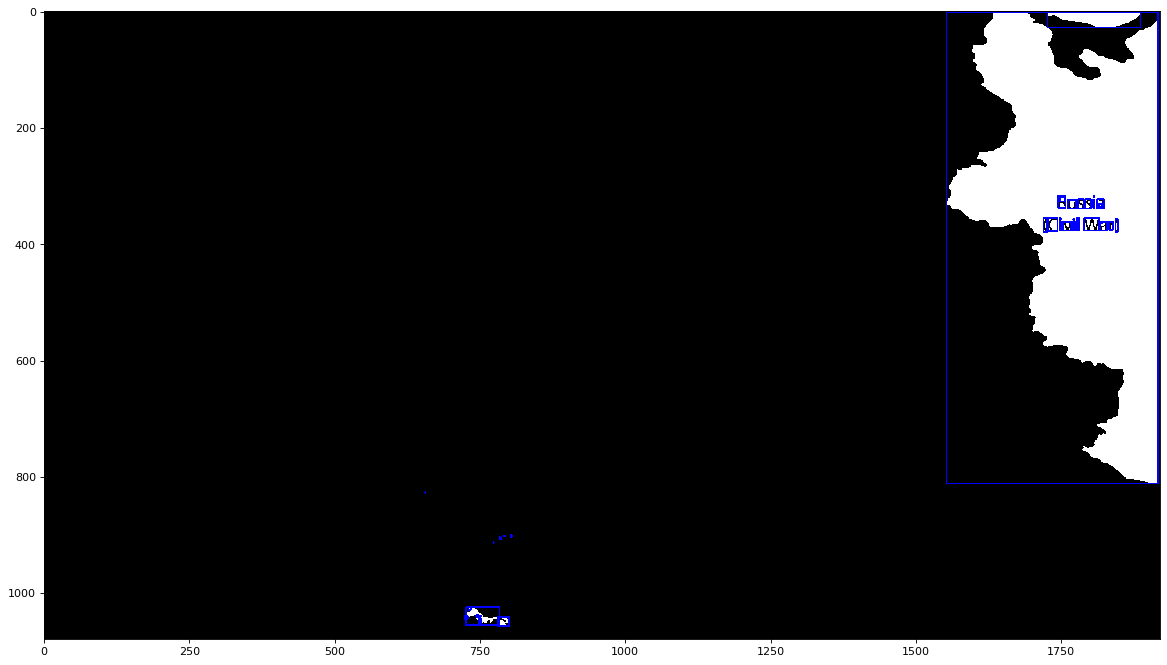

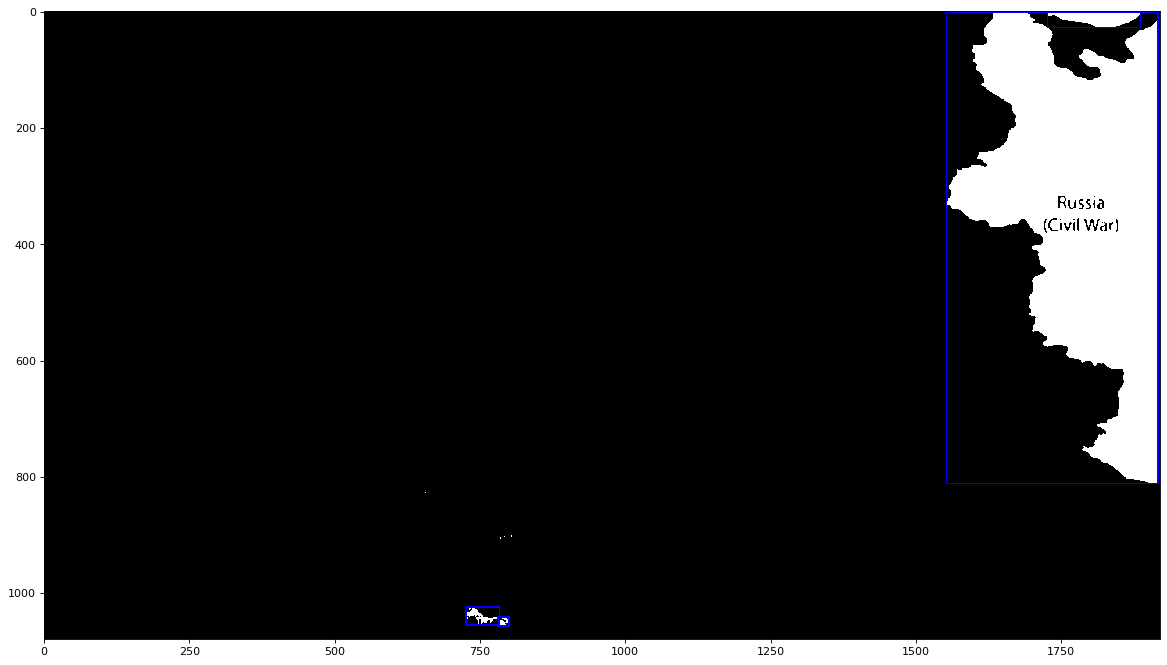

Kept  4 polygons


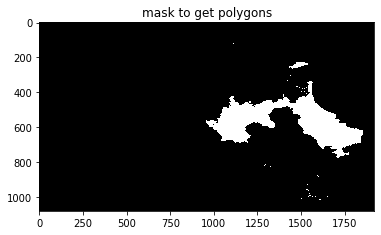

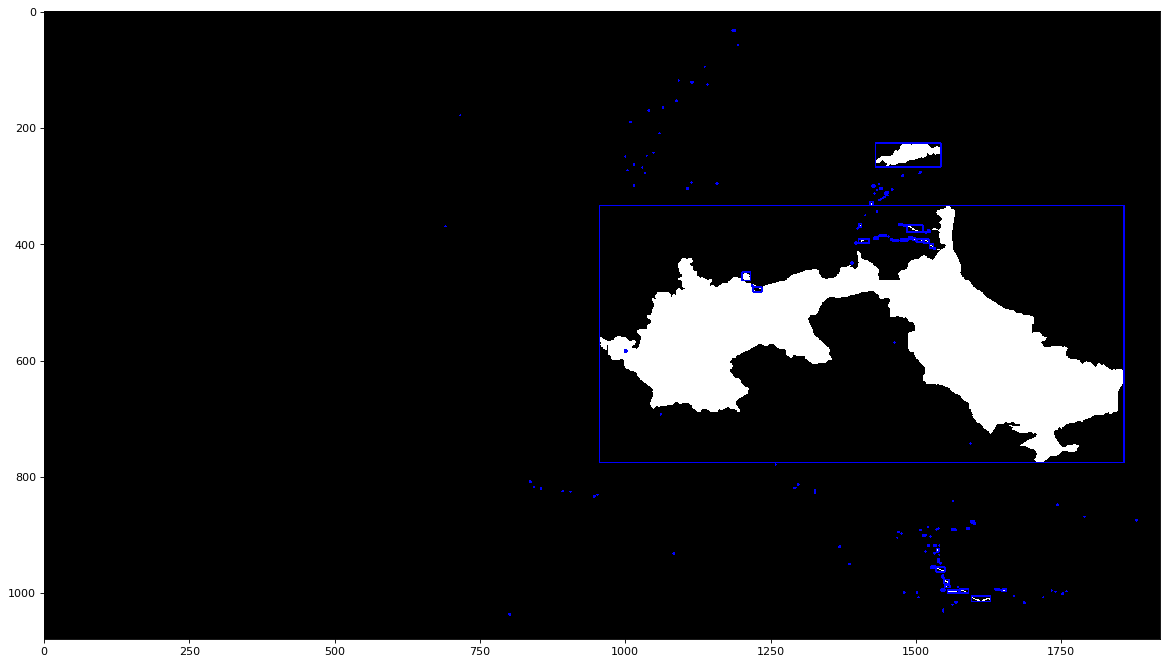

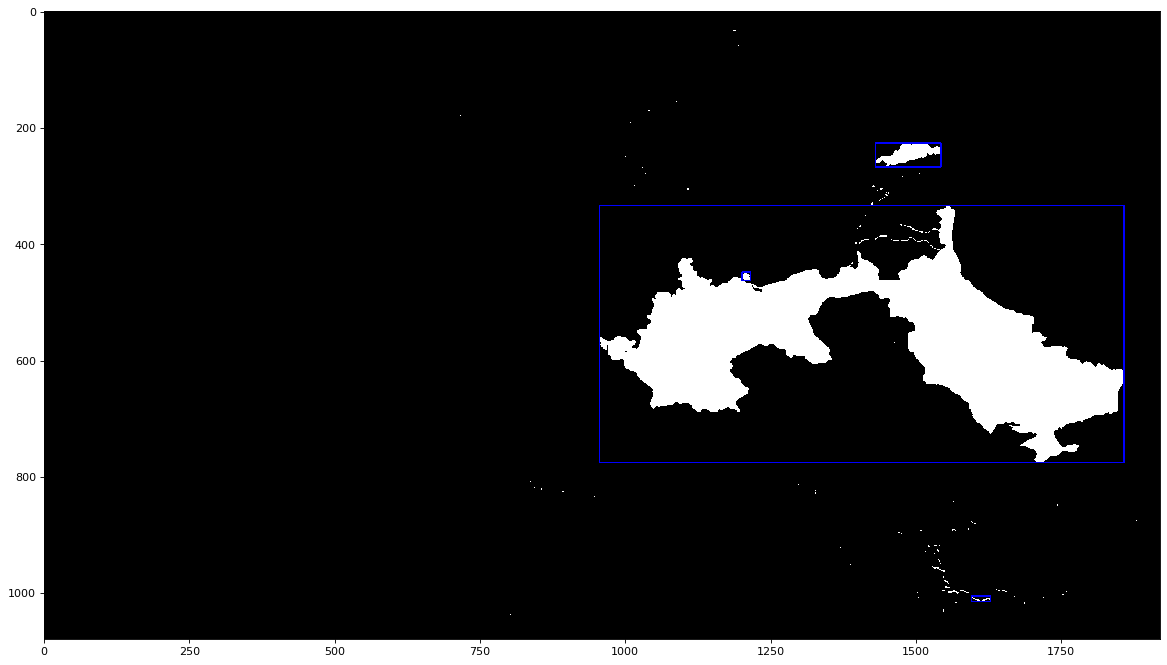

Kept  4 polygons


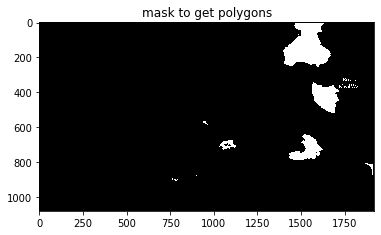

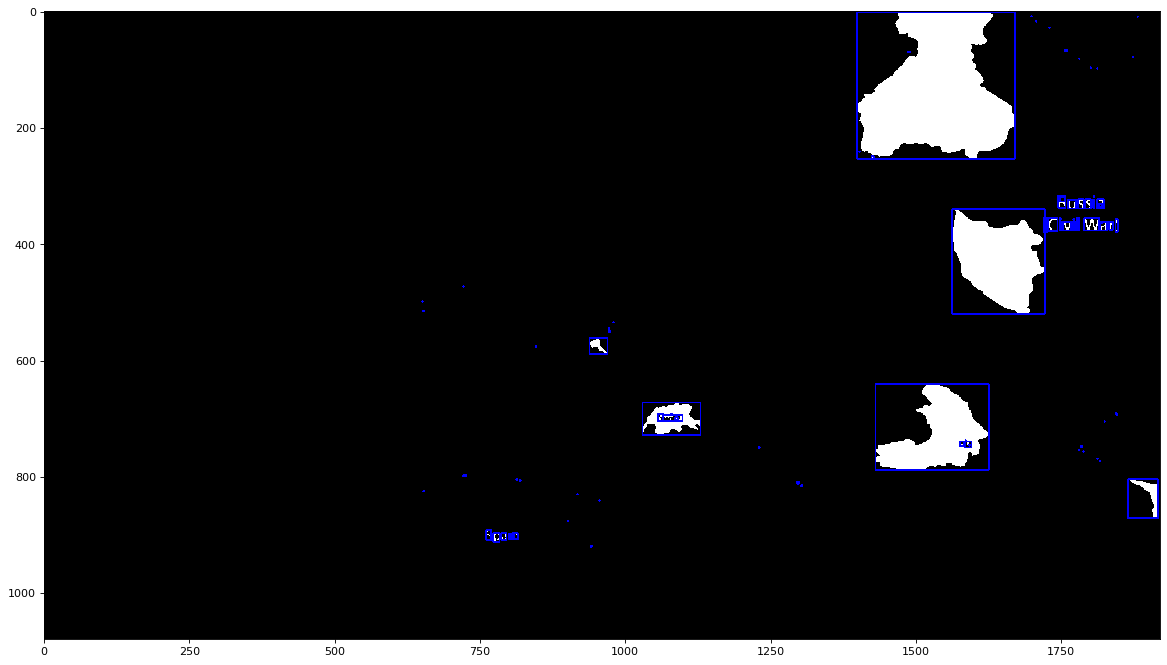

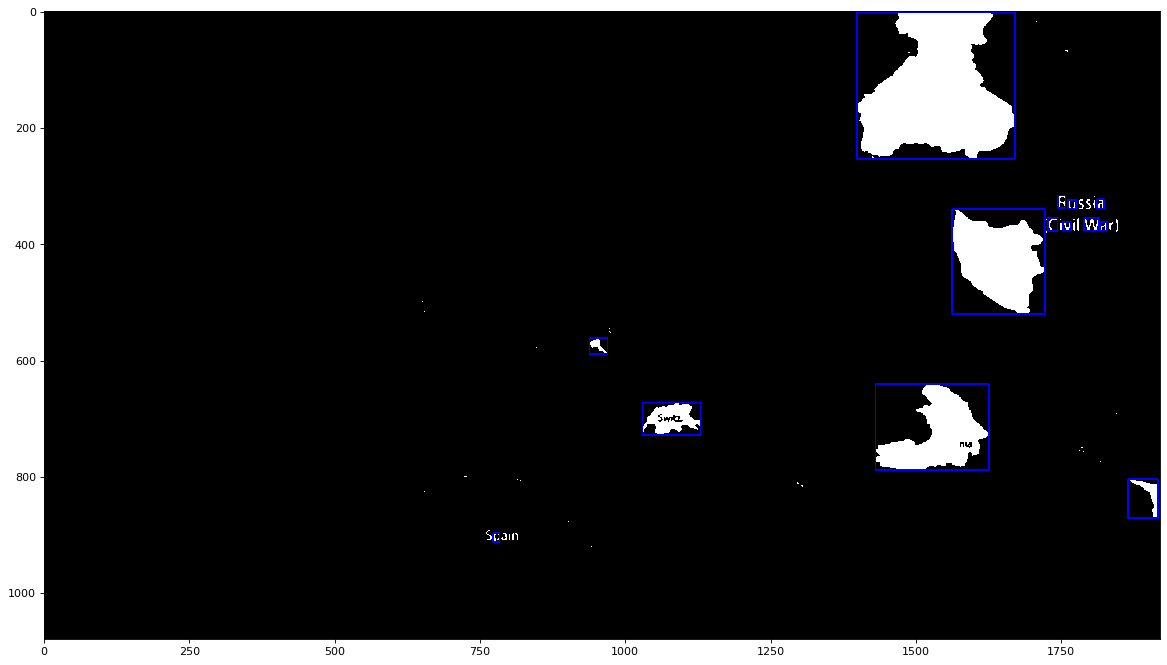

Kept  14 polygons


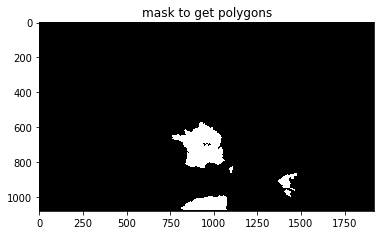

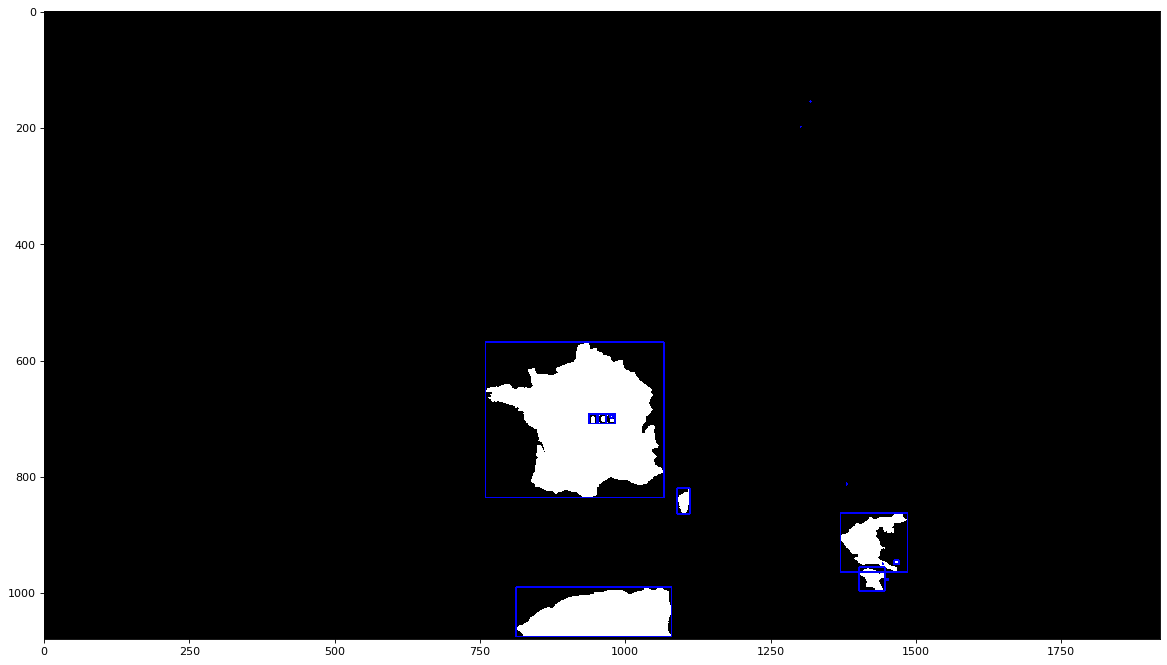

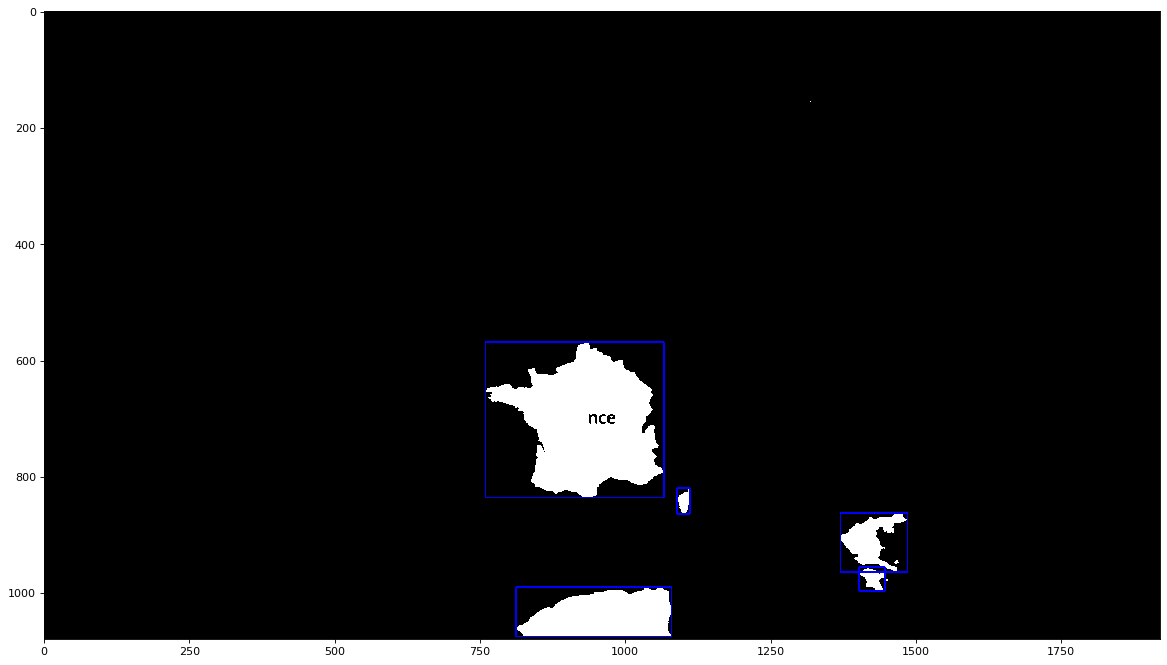

Kept  5 polygons


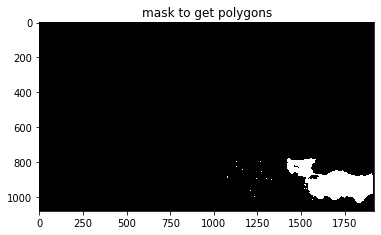

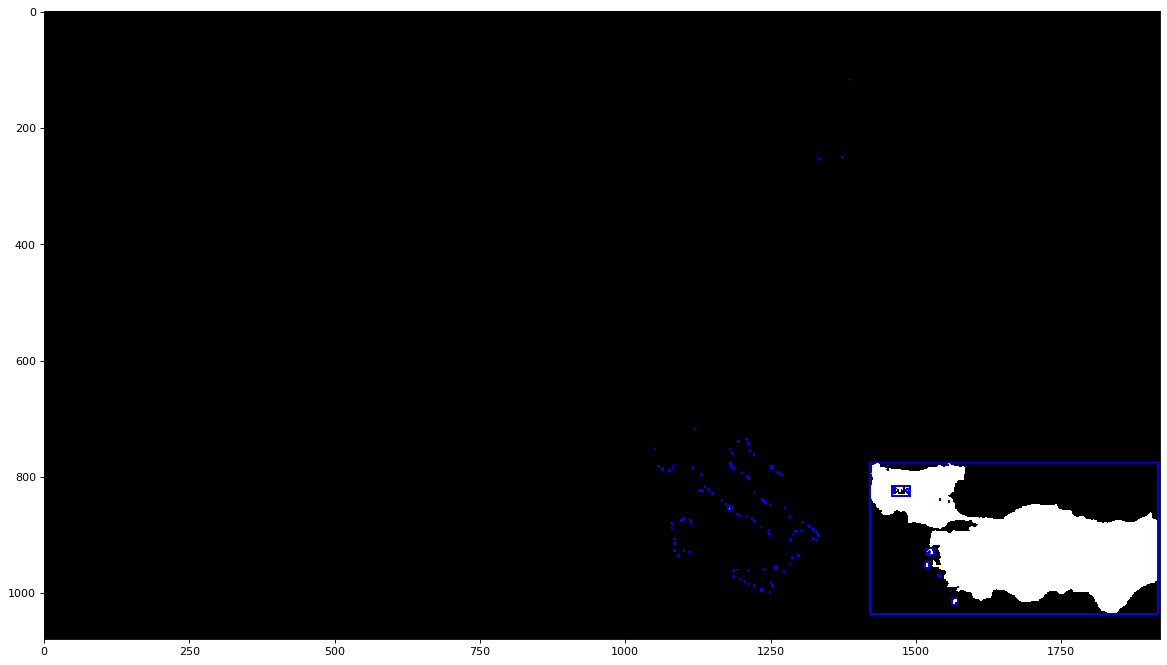

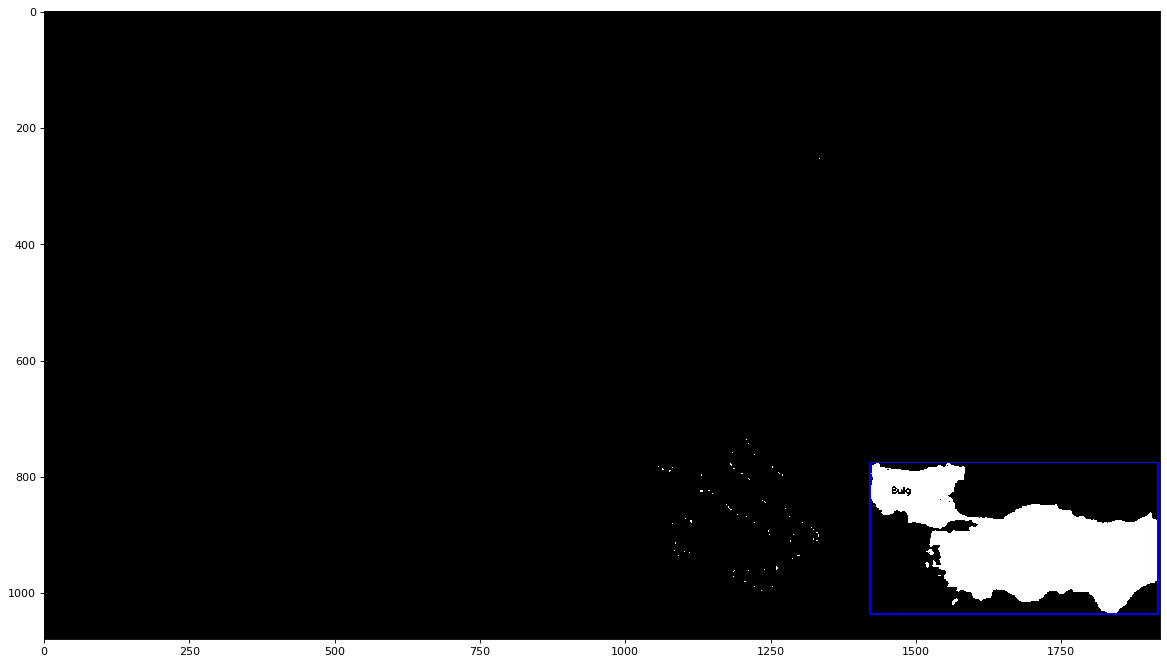

Kept  1 polygons


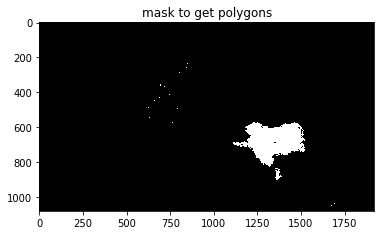

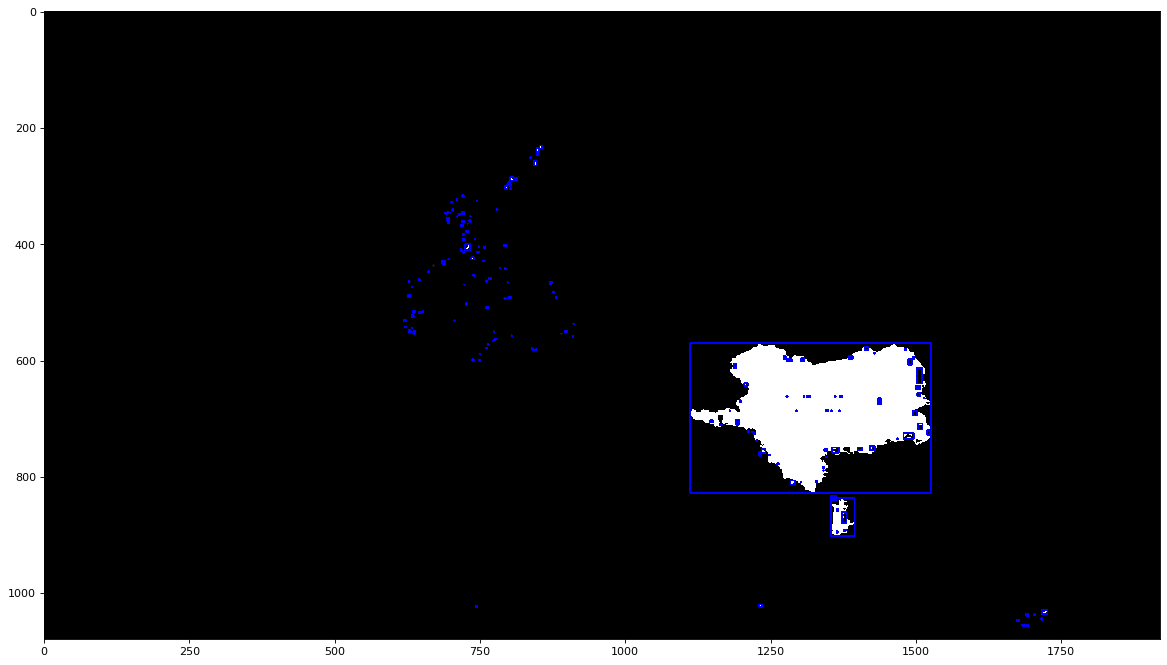

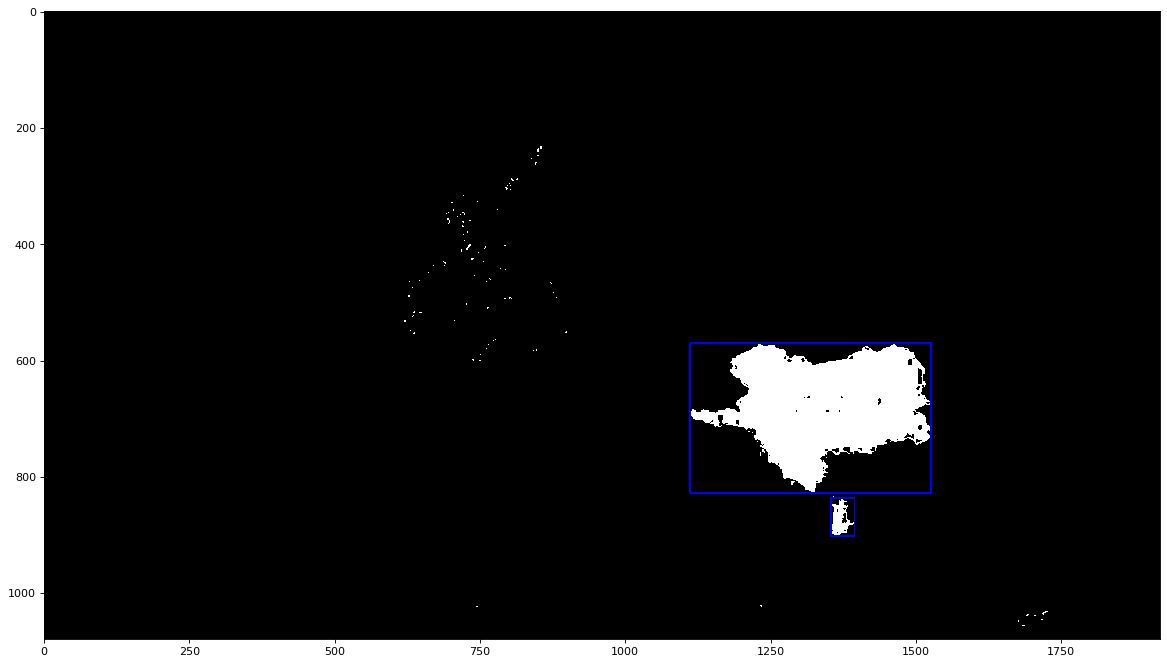

Kept  2 polygons


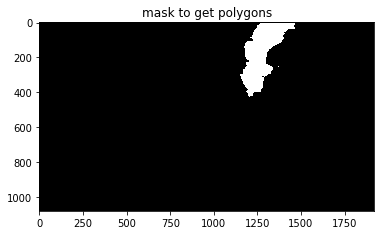

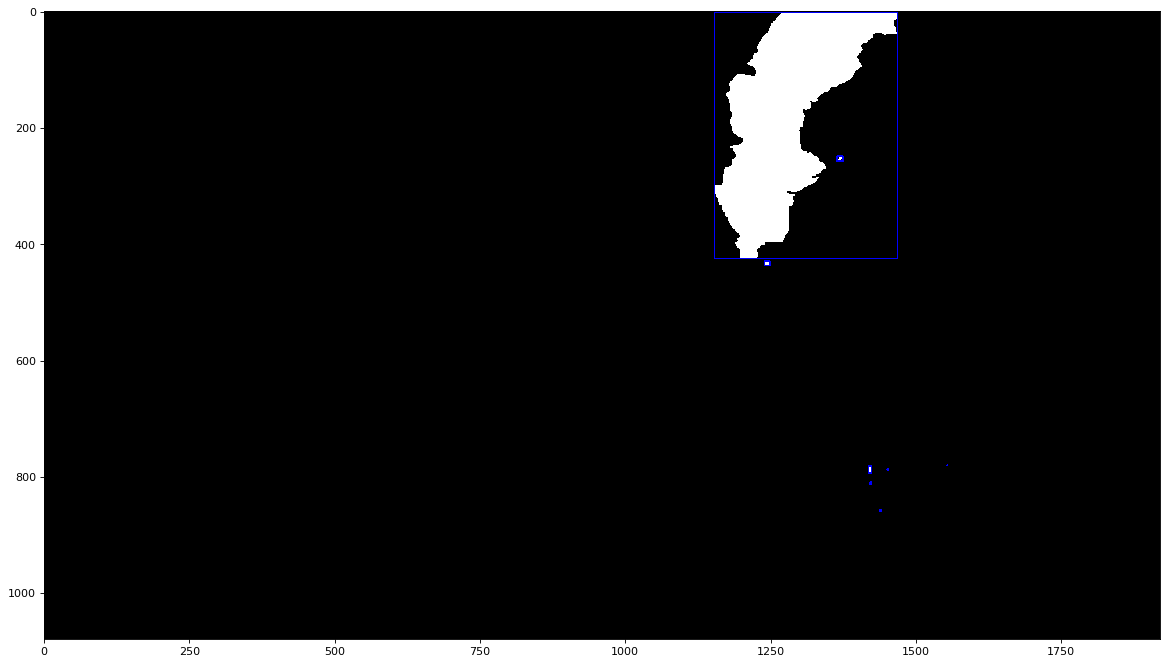

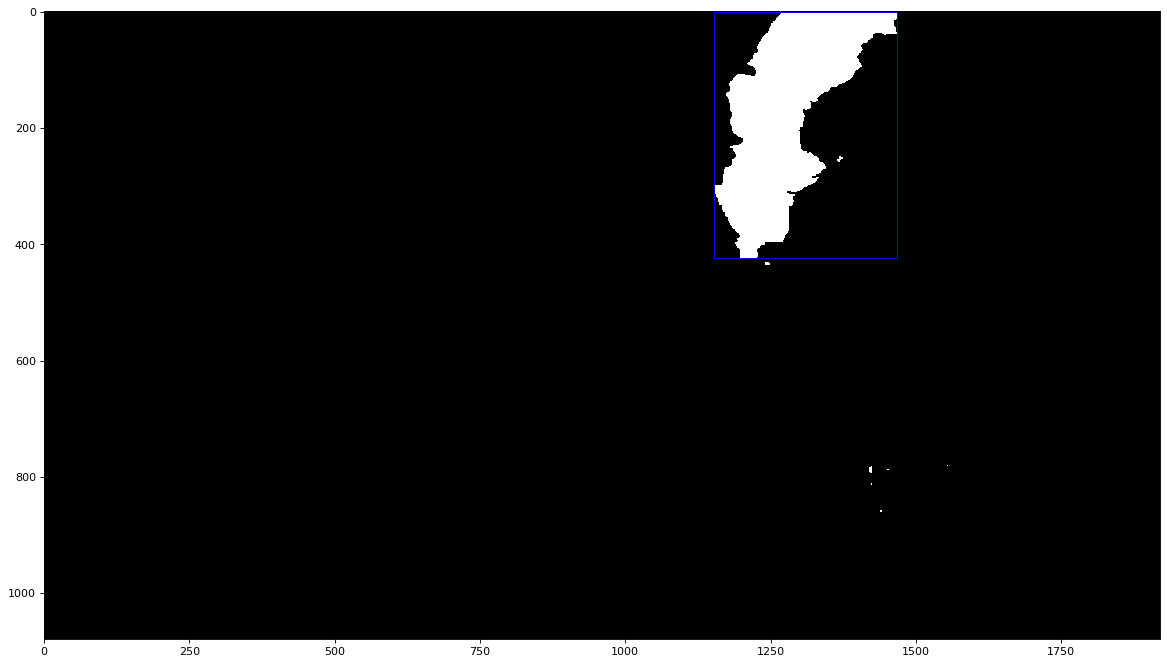

Kept  1 polygons


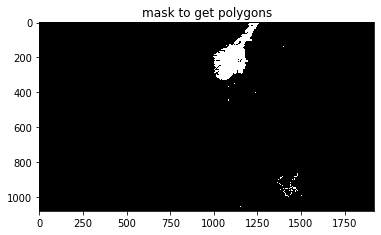

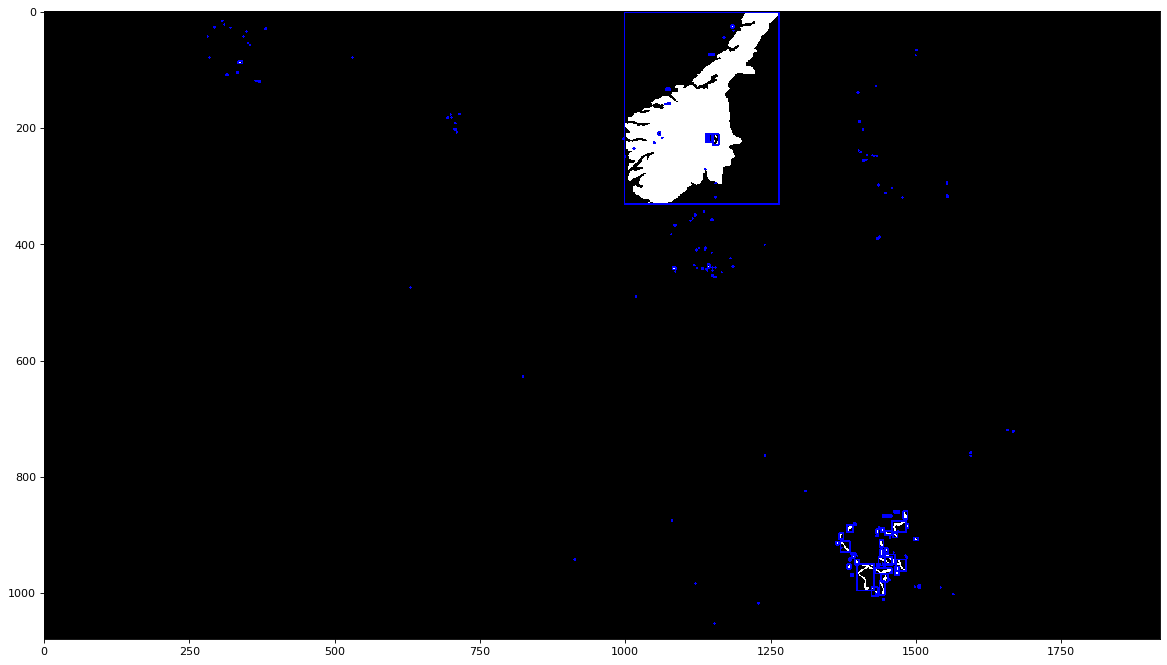

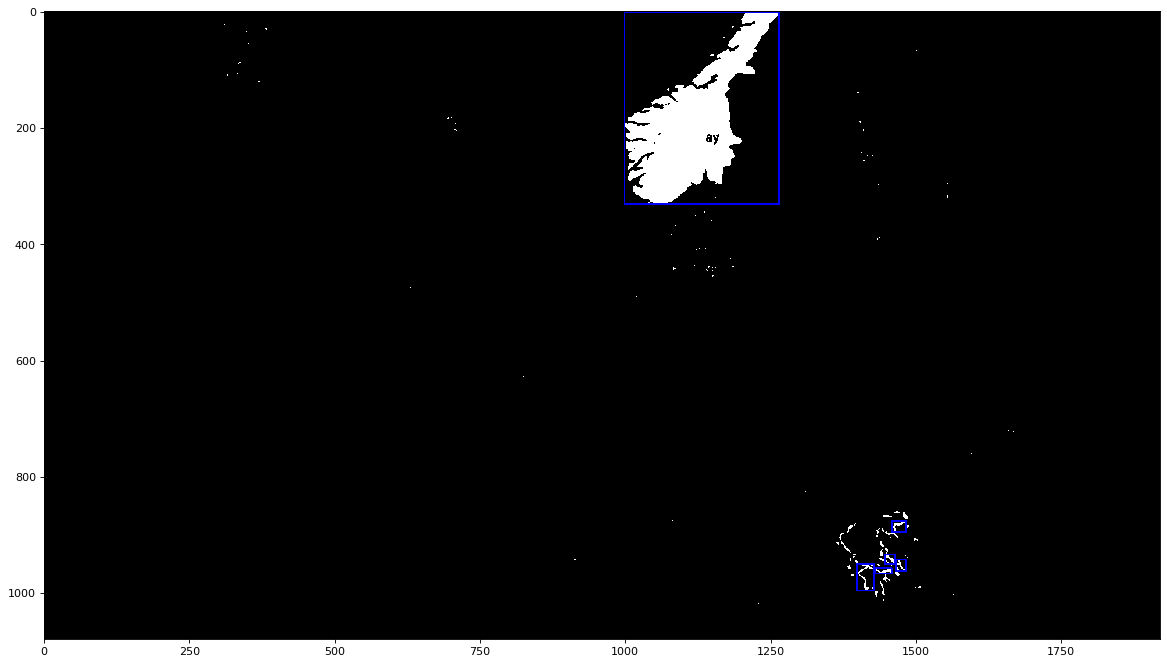

Kept  6 polygons


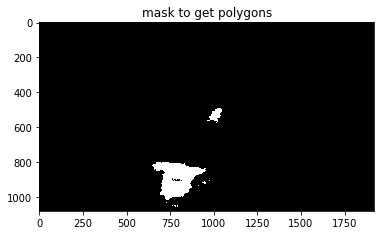

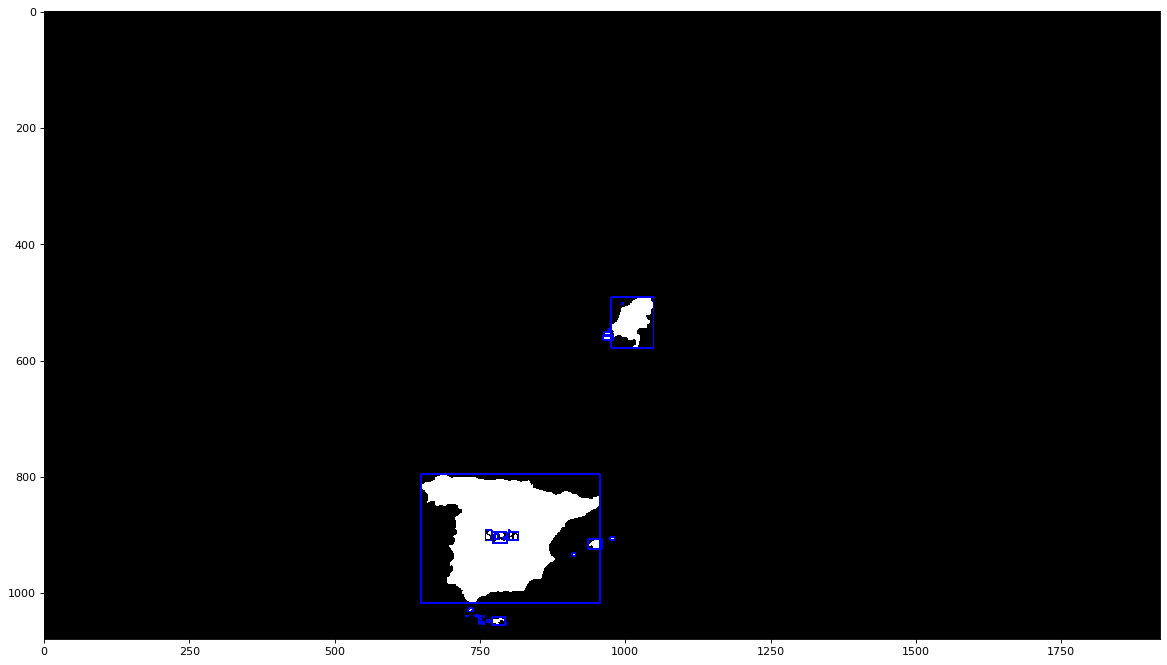

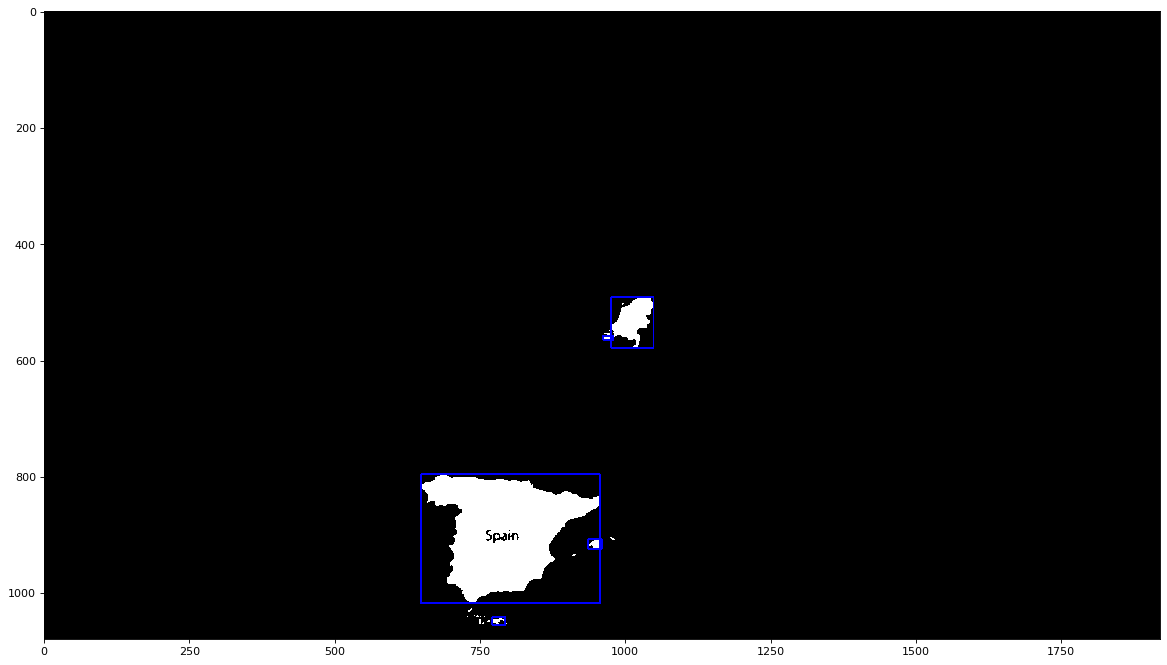

Kept  5 polygons


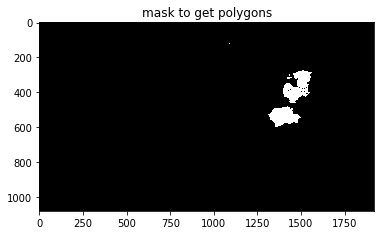

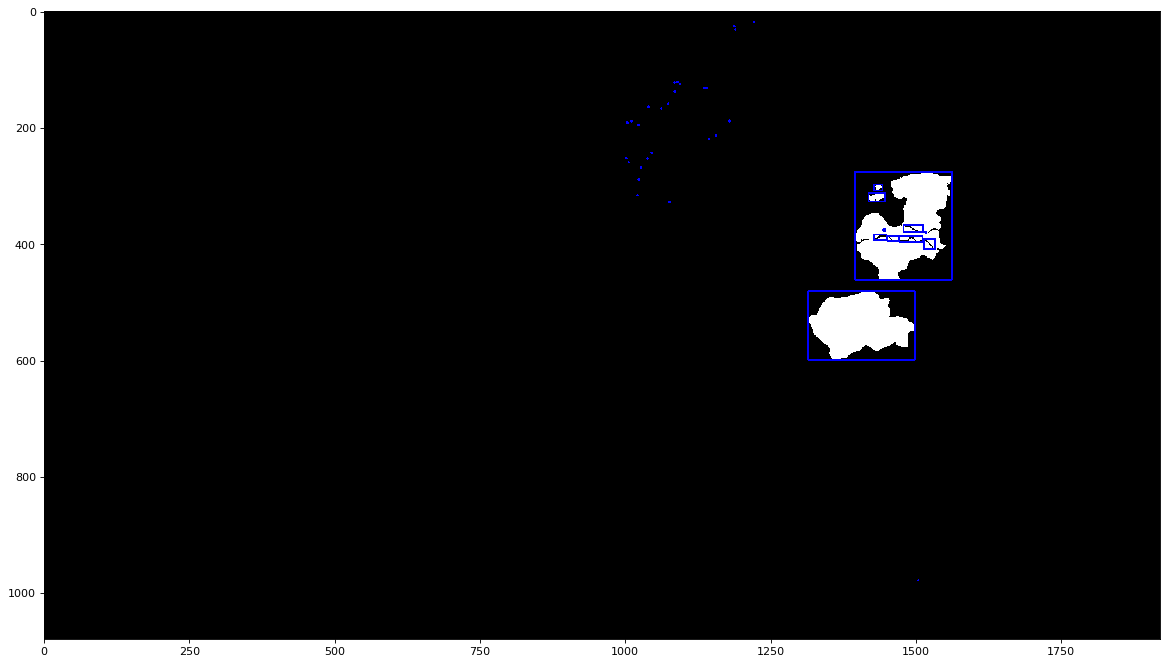

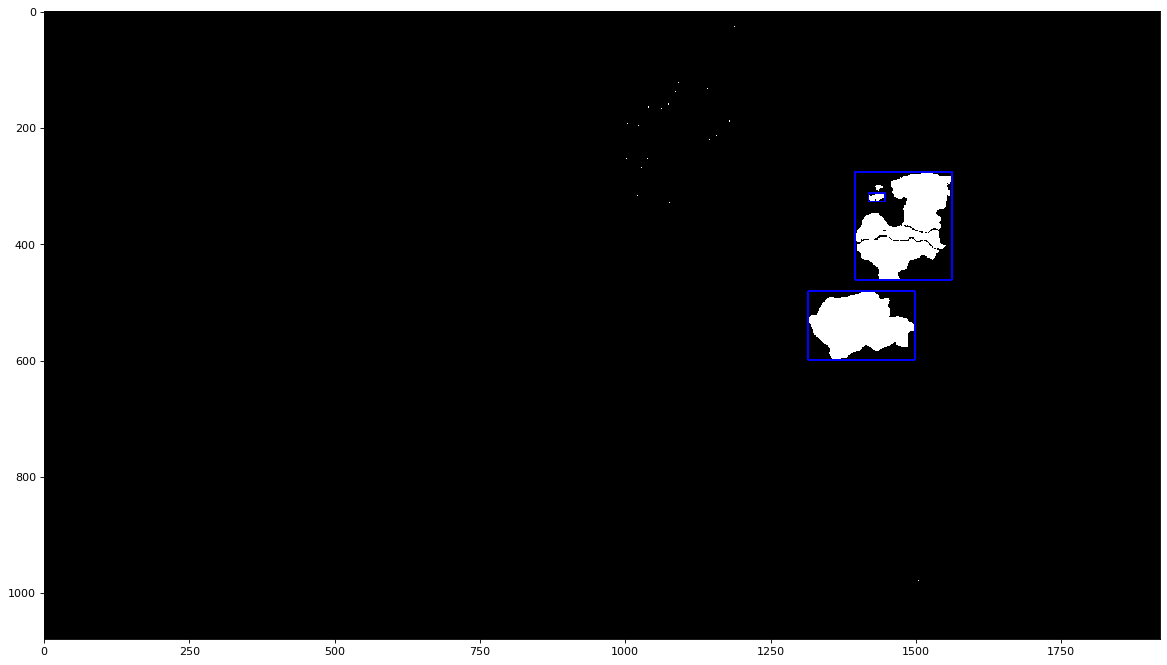

Kept  3 polygons


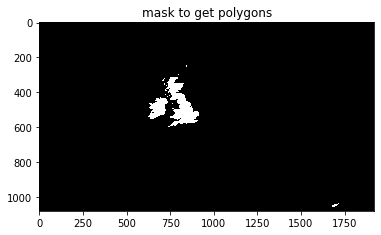

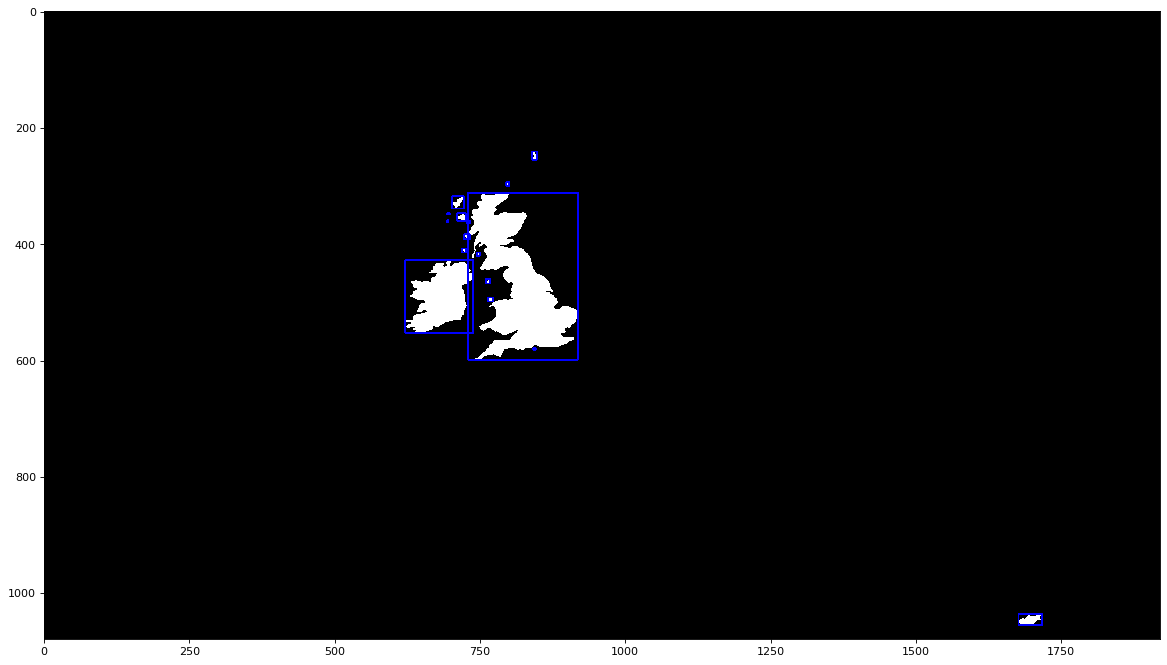

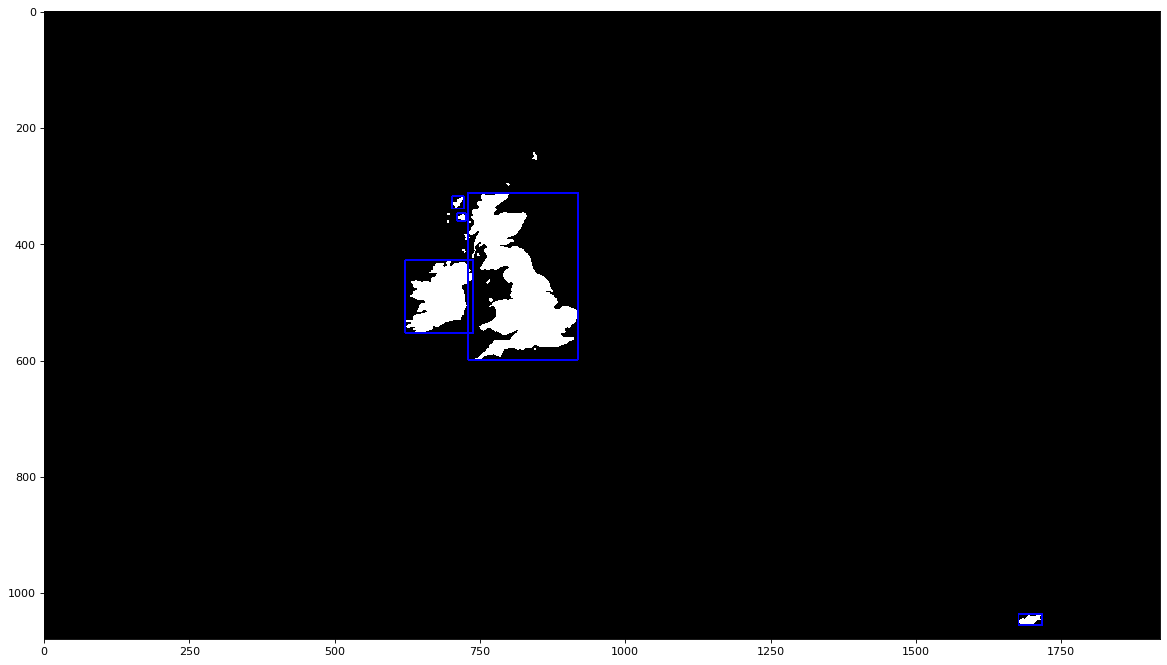

Kept  5 polygons


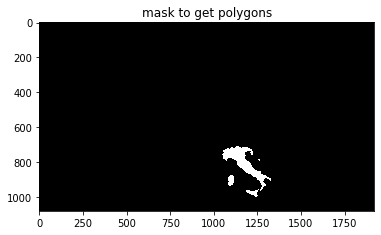

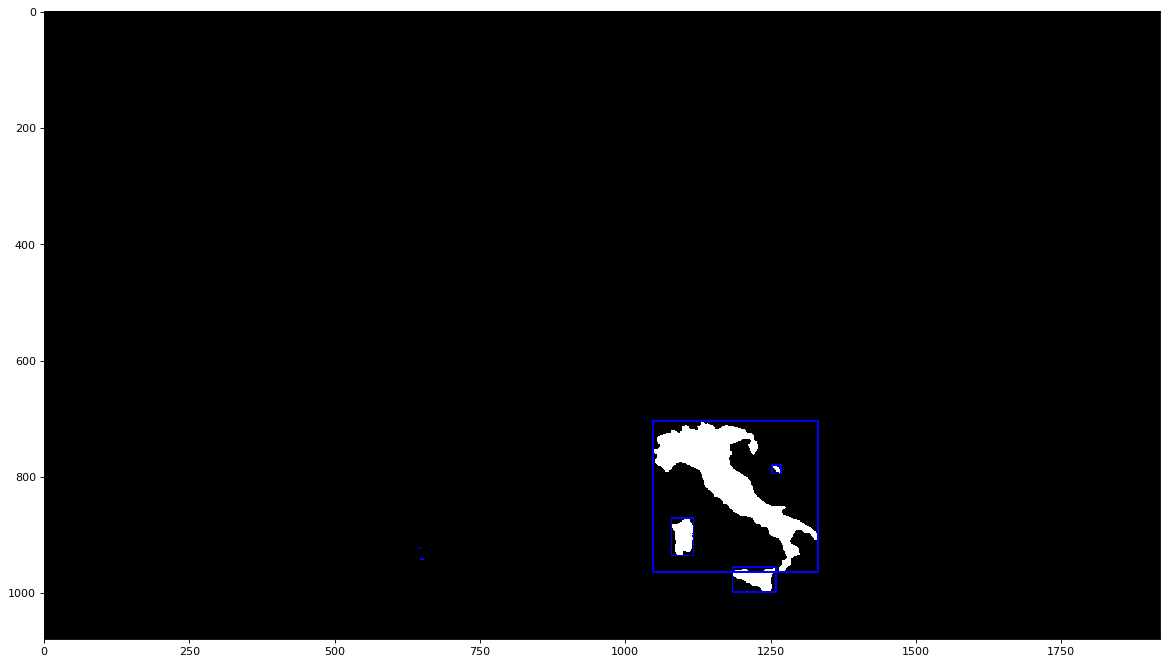

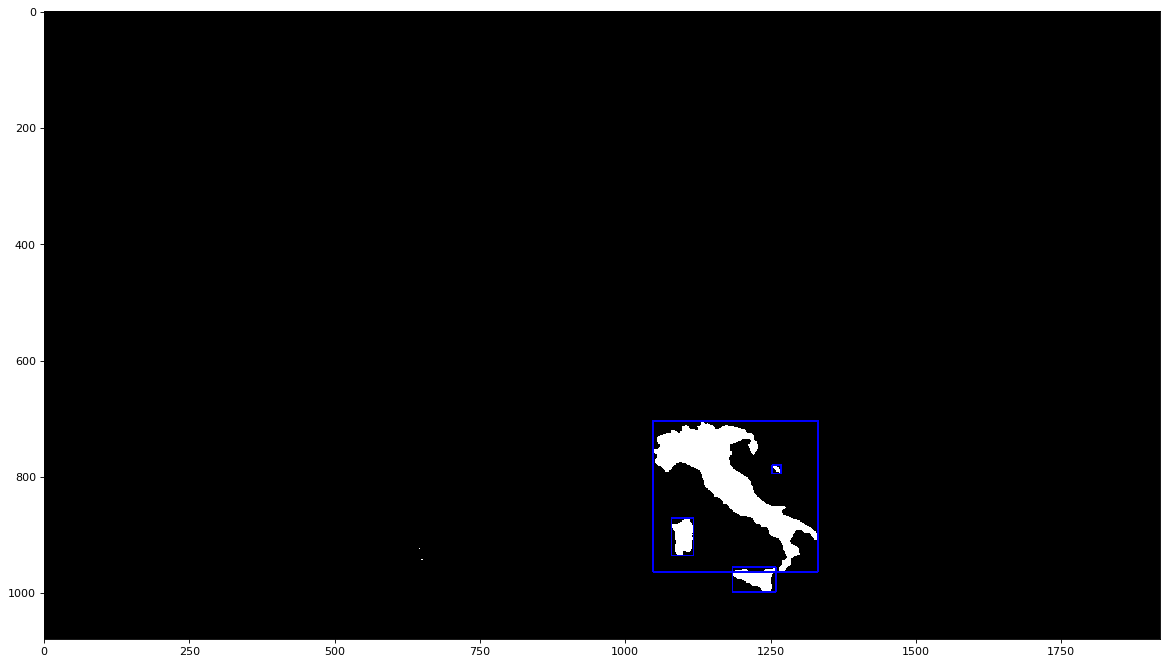

Kept  4 polygons


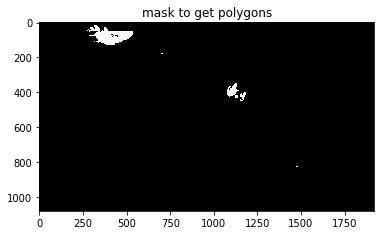

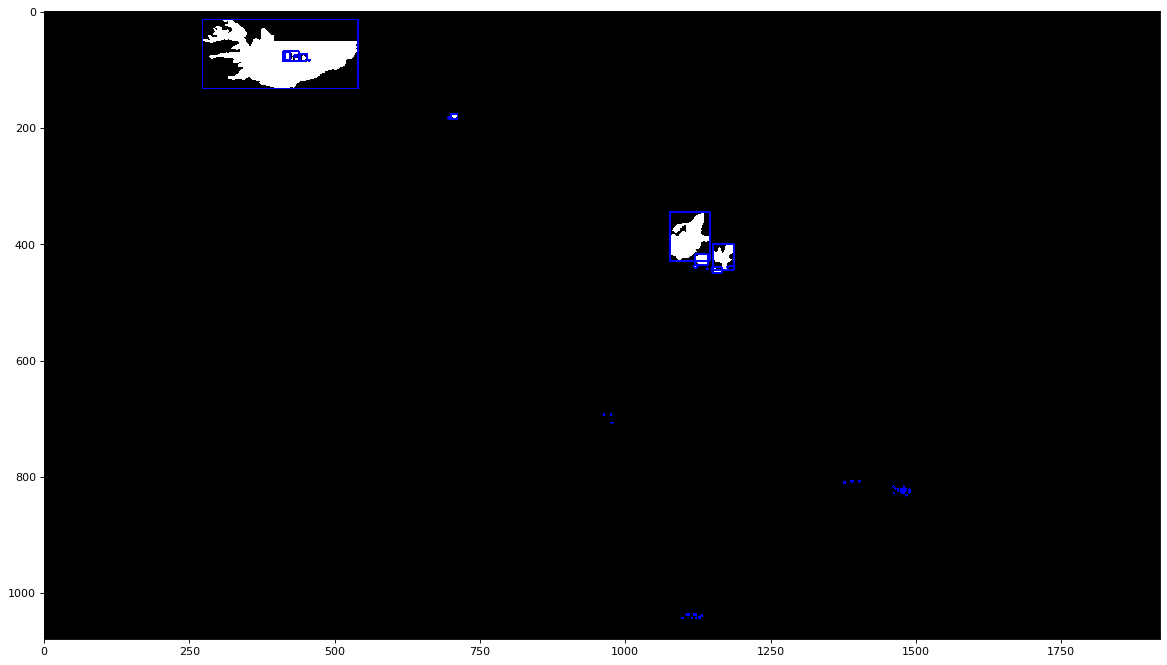

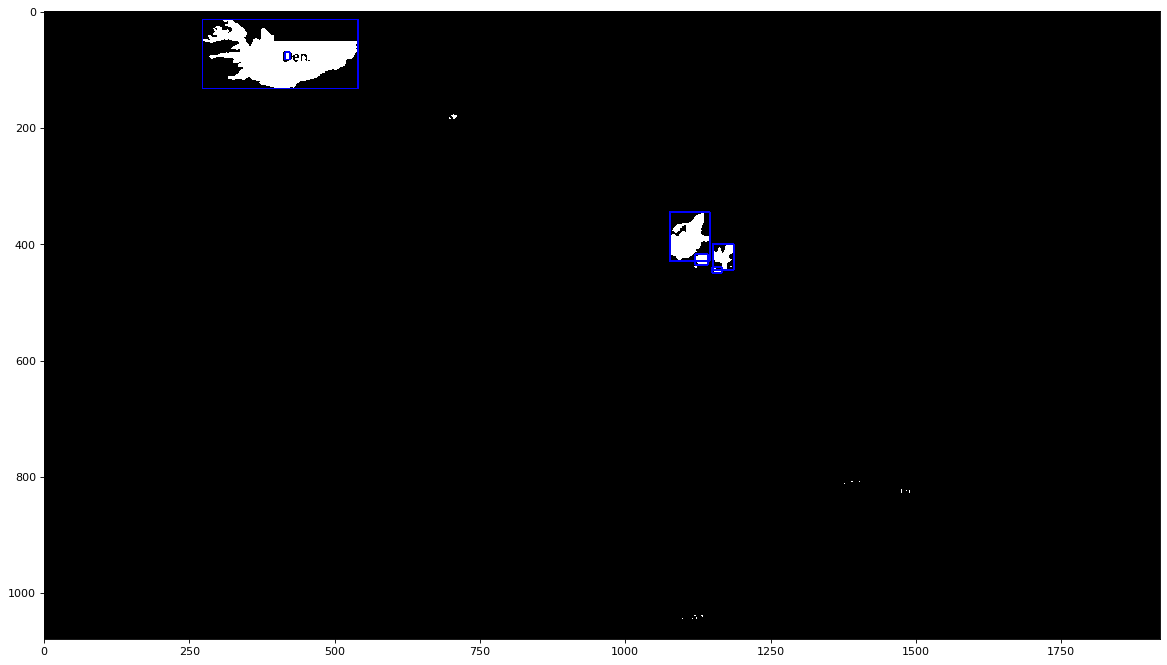

Kept  6 polygons


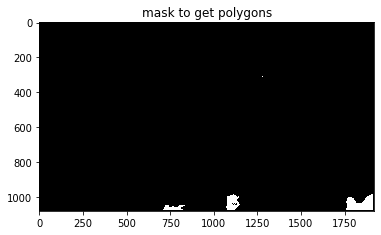

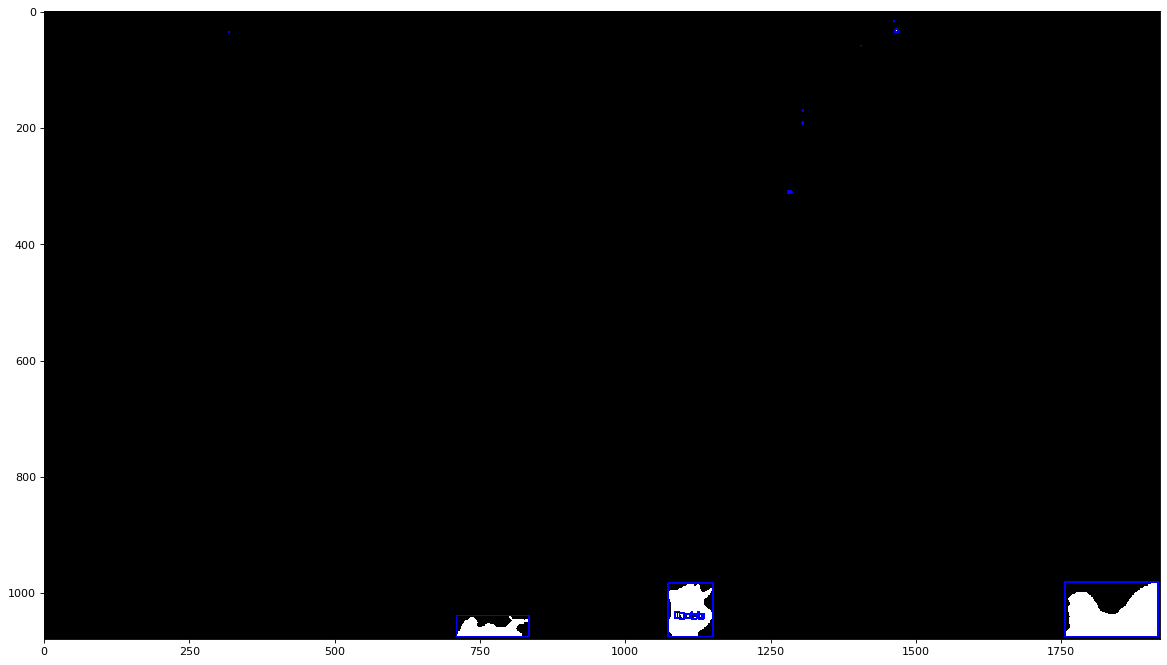

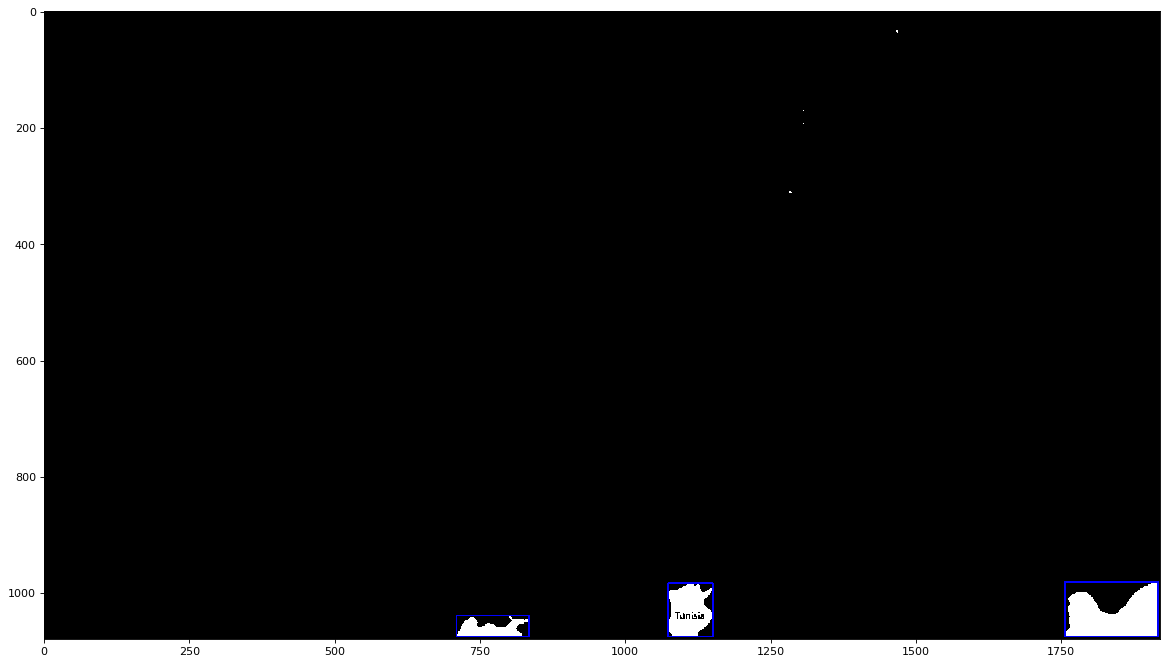

Kept  3 polygons


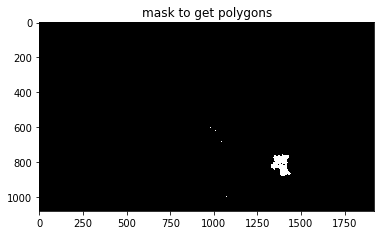

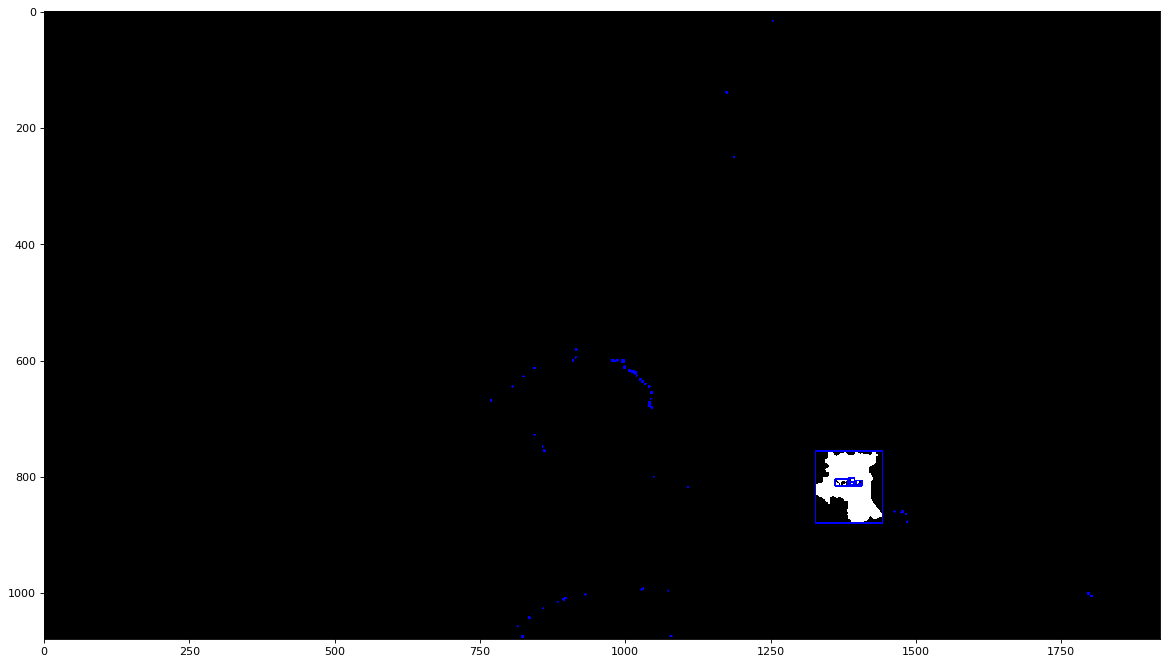

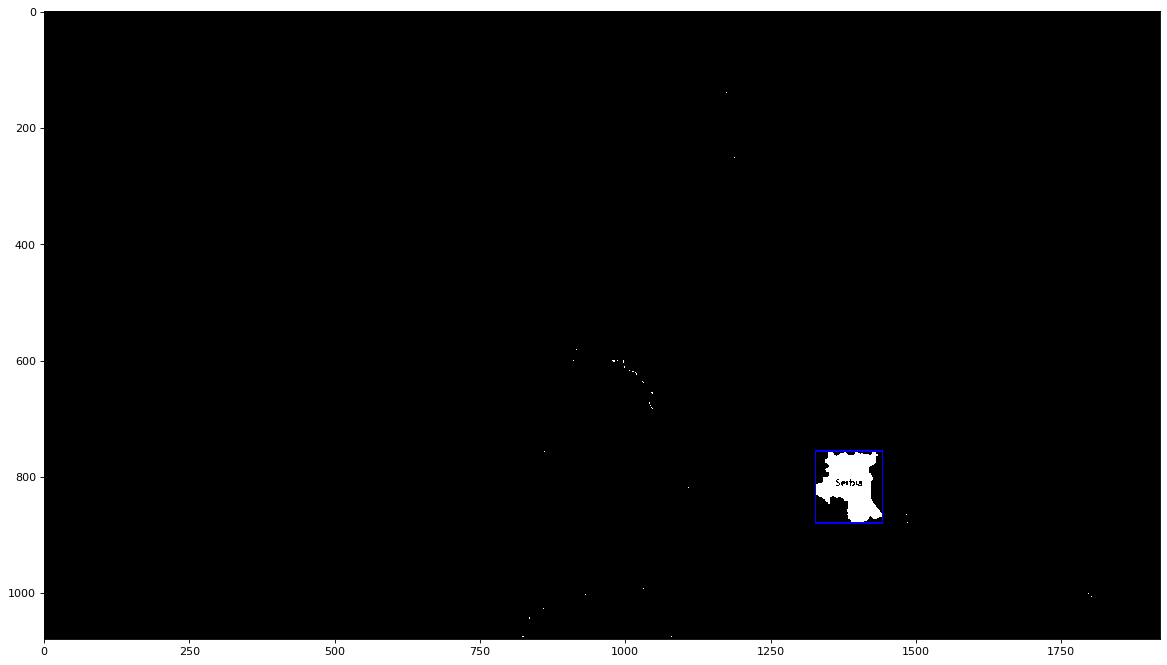

Kept  1 polygons


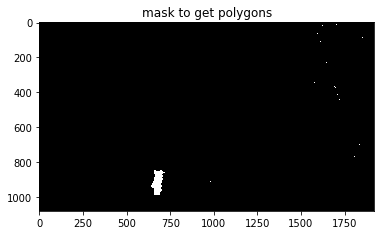

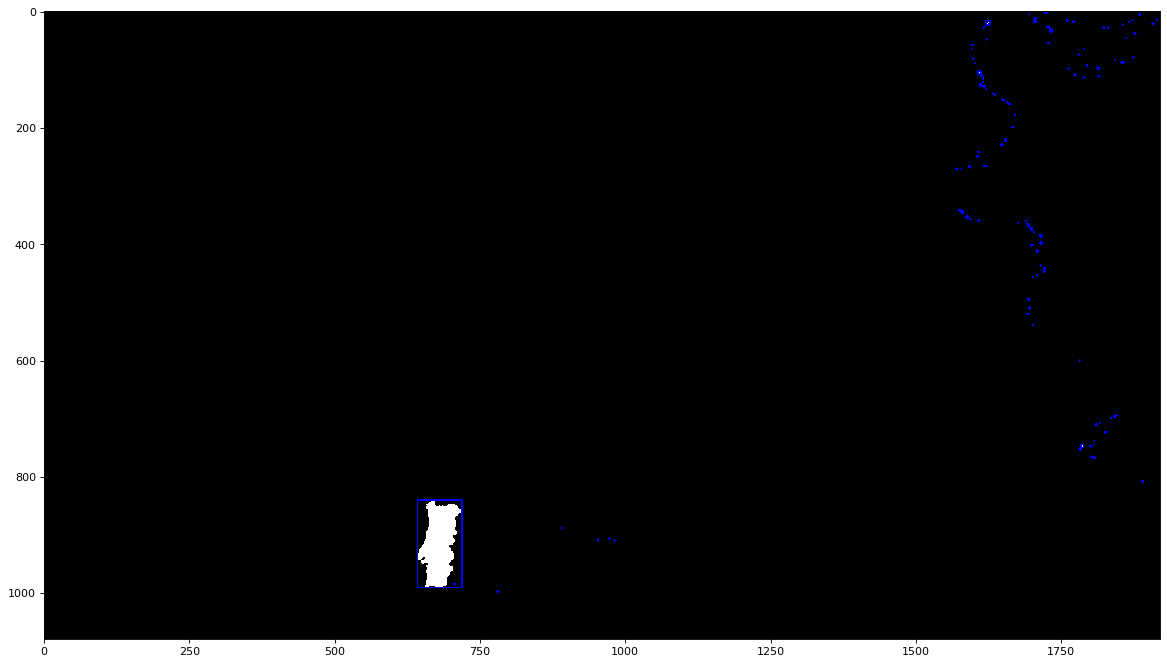

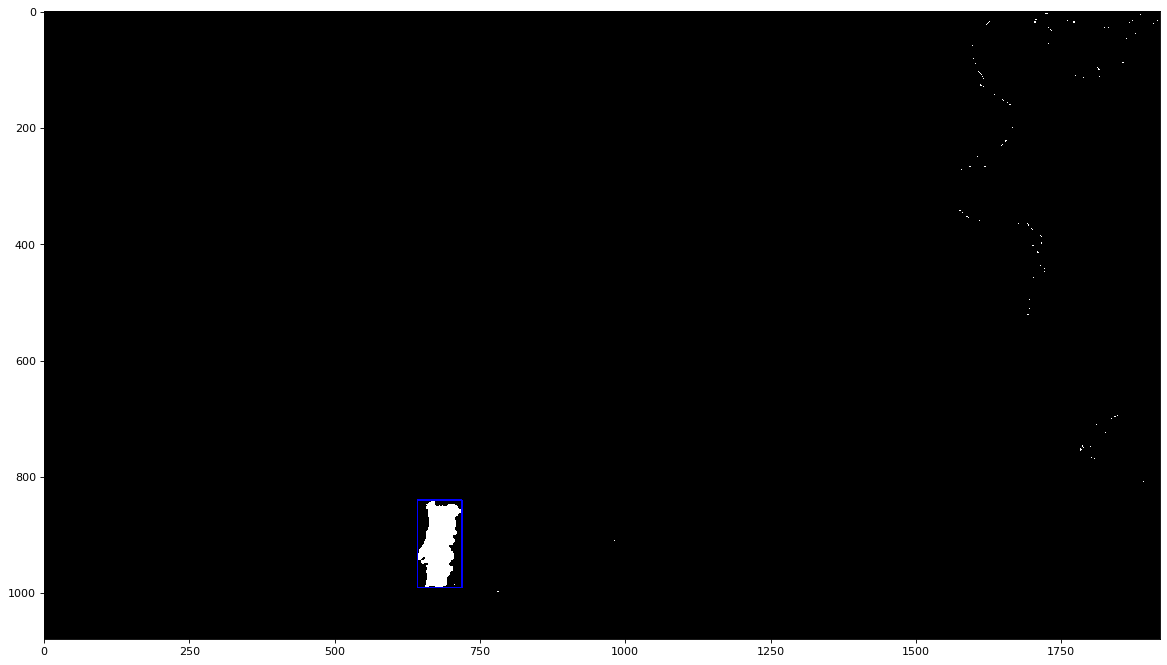

Kept  1 polygons


In [11]:
for mask in masks[:] :
    found_polygons = get_polygons(mask)
    display_img(mask, 'mask to get polygons')
    disp_polygons(skimage.color.gray2rgb(mask), found_polygons)
    kept_polygons = filter_polygons(found_polygons, mask)
    disp_polygons(skimage.color.gray2rgb(mask), kept_polygons)
    print('Kept ', len(kept_polygons), 'polygons')

In [12]:
end_time = time.time()
print('Elapsed time for notebook execution : ', end_time - start_time)

Elapsed time for notebook execution :  77.66238331794739
